# 08. Neural Networks Algorithms

## Simple model

### Data preparation

Import libraries and scaler:

In [1]:
# Import the third party libraries
import joblib
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau 
from tensorflow.keras.metrics import MeanAbsoluteError, MeanSquaredError, RootMeanSquaredError, R2Score  
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.regularizers import l2
# Import scaler
scaler = joblib.load("pkls/scaler.pkl")

Import the data from the csv-file:

In [2]:
df_grouped = pd.read_csv("csv/df_grouped.csv", index_col=0)

In [3]:
df_grouped

name  season    pts    reb   ast   blk    fga    fgm   
0              A.C. Green    1985  343.0  242.0  36.0  32.0  228.0  130.0  \
1              A.C. Green    1986  696.0  507.0  65.0  58.0  478.0  257.0   
2              A.C. Green    1987  834.0  616.0  81.0  32.0  561.0  284.0   
3              A.C. Green    1988  831.0  542.0  75.0  38.0  563.0  295.0   
4              A.C. Green    1989  728.0  494.0  64.0  36.0  553.0  255.0   
...                   ...     ...    ...    ...   ...   ...    ...    ...   
15576  Zydrunas Ilgauskas    2008  533.0  323.0  46.0  50.0  463.0  217.0   
15577  Zydrunas Ilgauskas    2009  351.0  264.0  39.0  43.0  336.0  147.0   
15578  Zydrunas Ilgauskas    2010  235.0  188.0  16.0  40.0  199.0  104.0   
15579      Zylan Cheatham    2019   10.0    6.0   2.0   0.0    7.0    5.0   
15580      Zylan Cheatham    2021   34.0   24.0   4.0   1.0   25.0   14.0   

         fta    ftm  ...  reb_scaled  ast_scaled  blk_scaled  fga_scaled   
0      130.0   82.0  ...    0.584318   -0.464939    0.510461   -0.269465  \
1      226.0  182.0  ...    2.358664   -0.180549    1.478240    0.615634   
2      346.0  266.0  ...    3.088489   -0.023644    0.510461    0.909486   
3      302.0  241.0  ...    2.593012   -0.082484    0.733795    0.916567   
4      276.0  207.0  ...    2.271621   -0.190356    0.659350    0.881163   
...      ...    ...  ...         ...         ...         ...         ...   
15576  111.0   91.0  ...    1.126665   -0.366874    1.180462    0.562528   
15577   63.0   48.0  ...    0.731622   -0.435519    0.919906    0.112898   
15578   35.0   27.0  ...    0.222753   -0.661070    0.808239   -0.372136   
15579    0.0    0.0  ...   -0.995855   -0.798362   -0.680650   -1.051892   
15580    5.0    4.0  ...   -0.875333   -0.778749   -0.643428   -0.988165   

       fgm_scaled  fta_scaled  ftm_scaled  turnover_scaled  age_scaled   
0       -0.069449    0.373497    0.160376         0.219002   -1.181264  \
1        0.882597    1.306460    1.403696         0.590877   -0.936562   
2        1.085000    2.472664    2.448084         1.045391   -0.447157   
3        1.167461    2.045056    2.137254         0.818134   -0.447157   
4        0.867604    1.792378    1.714526         0.694175   -0.202455   
...           ...         ...         ...              ...         ...   
15576    0.582740    0.188848    0.272275         0.198342    1.510459   
15577    0.057990   -0.277634   -0.262352        -0.194193    1.999864   
15578   -0.264356   -0.549748   -0.523449        -0.214853    1.999864   
15579   -1.006502   -0.889891   -0.859146        -1.041242   -0.691859   
15580   -0.939034   -0.841299   -0.809413        -0.979263   -0.202455   

       eff_scaled.1  
0         -0.021090  
1          1.218922  
2          1.152998  
3          1.476769  
4          1.084648  
...             ...  
15576      1.145182  
15577      0.040535  
15578     -0.240238  
15579     -0.936876  
15580     -0.329609  

[15581 rows x 27 columns]

### Feature engineering

Use pts, reb, ast, blk, fga, fgm, fta, ftm, turnover, age as the features, scale the x and y, and create a dataframe of scaled features:

In [4]:
scaled_features = ["pts_scaled", "reb_scaled", "ast_scaled", "blk_scaled", "fga_scaled", "fgm_scaled", "fta_scaled", "ftm_scaled", "turnover_scaled", "age_scaled"]
x_scaled = df_grouped[scaled_features]
y_scaled = df_grouped["eff_scaled"]

### Data splitting

Split the data on the training, validation and test datasets (80/10/10):

In [5]:
x_train, x_temp, y_train, y_temp = train_test_split(x_scaled.values.reshape(-1, 10), y_scaled.values.reshape(-1, 1), test_size=0.2, random_state=38)
x_val, x_test, y_val, y_test = train_test_split(x_temp, y_temp, test_size=0.5, random_state=38)
((x_train.shape, y_train.shape), (x_val.shape, y_val.shape), (x_test.shape, y_test.shape))

(((12464, 10), (12464, 1)), ((1558, 10), (1558, 1)), ((1559, 10), (1559, 1)))

### Build, Train and Evaluate the Model

Create a few functions to build, configure, train, evaluate, and visualize model that we will use multiple times:

Build the model:

In [6]:
def build_model(input_shape, model_name):
    """Builds the model."""
    # Set architecture
    model = Sequential(
        [
            Input(shape=(x_train.shape[1],), name="L1_Input_Layer"), 
            Dense(128, activation="relu", name="L2_Hidden_Layer_1"), 
            Dense(1, name="L3_Output_Layer")
        ],
        name=model_name
    )
    return model

Create r2-score metrics:

In [7]:
def r2_score(y_true, y_pred):
    """Calculates the R2-score (the default R2Score is not stable)."""
    SS_res =  tf.reduce_sum(tf.square(y_true - y_pred)) 
    SS_tot = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true))) 
    return (1 - SS_res / (SS_tot + tf.keras.backend.epsilon()))

Configure the model:

In [8]:
def compile_model(model):
    """Configures the model."""
    # Configure the model.
    model.compile(
        optimizer="adam", 
        loss="mse", 
        metrics=[
                 MeanAbsoluteError(), 
                 MeanSquaredError(), 
                 RootMeanSquaredError(), 
                 r2_score
                ]
    )
    # Model summary.
    model.summary()

Train the model:

In [9]:
def train_model(model):
    """Trains the model"""
    history = model.fit(
        x_train, y_train, 
        epochs=1000, 
        batch_size=128, 
        validation_data=(x_val, y_val)
    )
    return history

Save the model:

In [10]:
def save_model(model, path):
    """Saves model in SavedModel Format."""
    model.save(path)

Save the history:

In [11]:
def save_history(history, path):
    """Saves the training history as JSON-file."""
    history_dict = history.history
    # Sometimes, the history contains values of type numpy.float32 (e.g., 
    # due to ReduceLROnPlateau). These values can cause serialization errors 
    # when saving to JSON, so we convert them to the standard float type.
    for key, values in history_dict.items():
        history_dict[key] = [float(i) if isinstance(i, np.float32) else i for i in values]
    # Open and write to the JSON file.
    with open(path, "w") as f:
        json.dump(history_dict, f)

Run the functions:

In [12]:
model_name = "one_layer_128"
# Build the model.
model = build_model((x_train.shape[1],), model_name)
# Configure the model.
compile_model(model)
# Save the model.
save_model(model, f"models/{model_name}")
# Train the model.
history = train_model(model)
# Save the history.
save_history(history, f"history/{model_name}.json")
# Evaluate the model.
results = model.evaluate(x_test, y_test)

Metal device set to: Apple M1
Model: "one_layer_128"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L2_Hidden_Layer_1 (Dense)   (None, 128)               1408      
                                                                 
 L3_Output_Layer (Dense)     (None, 1)                 129       
                                                                 
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

INFO:tensorflow:Assets written to: models/one_layer_128/assets


INFO:tensorflow:Assets written to: models/one_layer_128/assets


Epoch 1/1000
98/98 [==============================] - 1s 10ms/step - loss: 0.2323 - mean_absolute_error: 0.3263 - mean_squared_error: 0.2323 - root_mean_squared_error: 0.4819 - r2_score: 0.7668 - val_loss: 0.1705 - val_mean_absolute_error: 0.2820 - val_mean_squared_error: 0.1705 - val_root_mean_squared_error: 0.4129 - val_r2_score: 0.8193
Epoch 2/1000
98/98 [==============================] - 1s 7ms/step - loss: 0.1413 - mean_absolute_error: 0.2606 - mean_squared_error: 0.1413 - root_mean_squared_error: 0.3759 - r2_score: 0.8564 - val_loss: 0.1601 - val_mean_absolute_error: 0.2682 - val_mean_squared_error: 0.1601 - val_root_mean_squared_error: 0.4001 - val_r2_score: 0.8315
Epoch 3/1000
98/98 [==============================] - 1s 7ms/step - loss: 0.1328 - mean_absolute_error: 0.2513 - mean_squared_error: 0.1328 - root_mean_squared_error: 0.3644 - r2_score: 0.8653 - val_loss: 0.1515 - val_mean_absolute_error: 0.2634 - val_mean_squared_error: 0.1515 - val_root_mean_squared_error: 0.3893 - 

### Visualize the results

Visualize the results:

In [13]:
def visualize_loss(history, results):
    """Visualizes training history."""
    # Create the df 
    df_hist = pd.DataFrame(history.history)
    # Draw the plots.
    plt.figure(figsize=(12, 7))
    plt.title("Training, Validation, and Test Loss vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid()
    plt.plot(
        df_hist.index, 
        df_hist[["loss", "val_loss"]], 
        label=["Training Loss", "Validation Loss"]
    )
    # Add the test line.
    plt.plot([0, 1000], [results[0], results[0]], label="Test Loss")
    # Add legend.
    plt.legend()

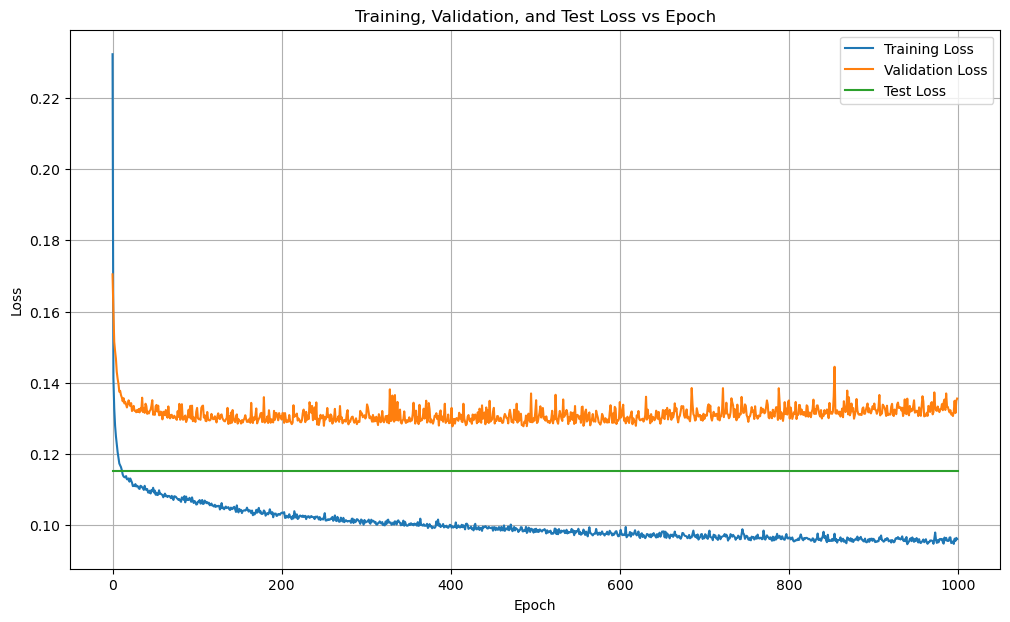

In [14]:
visualize_loss(history, results)

<div style="text-align: center;">
    Fig. 8.1. Training, Validation, and Test Loss vs Epoch.
</div>

In [15]:
def visualize_r2_score(history, results):
    """Visualizes training history."""
    # Create the df 
    df_hist = pd.DataFrame(history.history)
    # Draw the plots.
    plt.figure(figsize=(12, 7))
    plt.title("Training, Validation, and Test R2-score vs Epoch")
    plt.xlabel("Epoch")
    plt.ylabel("R2-score")
    plt.grid()
    plt.plot(
        df_hist.index, 
        df_hist[["r2_score", "val_r2_score"]], 
        label=["Training R2-score", "Validation R2-score"]
    )
    # Add the test line.
    plt.plot([0, 1000], [results[4], results[4]], label="Test R2-score")
    # Add legend.
    plt.legend()

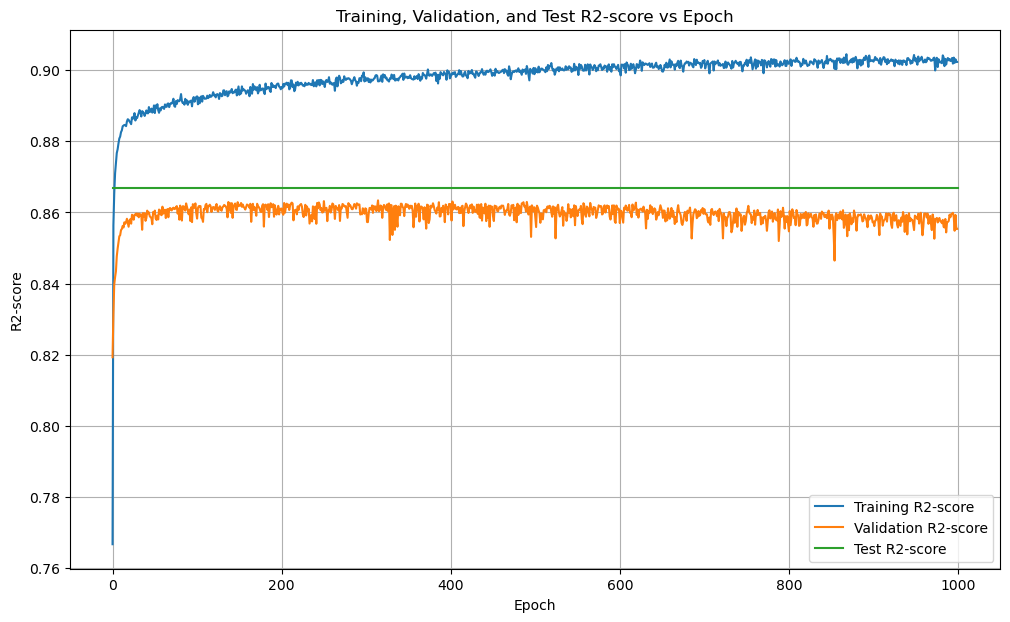

In [16]:
visualize_r2_score(history, results)

<div style="text-align: center;">
    Fig. 8.2. Training, Validation, and Test R2-score vs Epoch.
</div>

The final R2-score:

In [17]:
r2_score_dict = {}

In [18]:
r2_score_dict[f"{model_name}"] = {
        "r2_score_train": round(history.history["r2_score"][-1], 4), 
        "r2_score_val": round(history.history["val_r2_score"][-1], 4), 
        "r2_score_test": round(results[4], 4)
}

In [19]:
r2_score_dict[f"{model_name}"]

{'r2_score_train': 0.9023, 'r2_score_val': 0.8554, 'r2_score_test': 0.8668}

## 2 Layers

### Build, Train and Evaluate the Model

Build the model:

In [20]:

def build_model(input_shape, model_name):
    """Builds the model."""
    # Set architecture.
    model = Sequential(
        [
            Input(shape=(x_train.shape[1],), name="L1_Input_Layer"), 
            Dense(128, activation="relu", name="L2_Hidden_Layer_1"), 
            Dense(64, activation="relu", name="L3_Hidden_Layer_2"), 
            Dense(1, name="L4_Output_Layer")
        ],
        name=model_name
    )
    return model

Run the functions:

In [21]:
model_name = "two_layers_128_64"
# Build the model.
model = build_model((x_train.shape[1],), model_name)
# Configure the model.
compile_model(model)
# Save the model.
save_model(model, f"models/{model_name}")
# Train the model.
history = train_model(model)
# Save the history.
save_history(history, f"history/{model_name}.json")
# Evaluate the model.
results = model.evaluate(x_test, y_test)

Model: "two_layers_128_64"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L2_Hidden_Layer_1 (Dense)   (None, 128)               1408      
                                                                 
 L3_Hidden_Layer_2 (Dense)   (None, 64)                8256      
                                                                 
 L4_Output_Layer (Dense)     (None, 1)                 65        
                                                                 
Total params: 9729 (38.00 KB)
Trainable params: 9729 (38.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: models/two_layers_128_64/assets


INFO:tensorflow:Assets written to: models/two_layers_128_64/assets


Epoch 1/1000
98/98 [==============================] - 1s 11ms/step - loss: 0.1830 - mean_absolute_error: 0.2872 - mean_squared_error: 0.1830 - root_mean_squared_error: 0.4278 - r2_score: 0.8177 - val_loss: 0.1594 - val_mean_absolute_error: 0.2588 - val_mean_squared_error: 0.1594 - val_root_mean_squared_error: 0.3992 - val_r2_score: 0.8293
Epoch 2/1000
98/98 [==============================] - 1s 10ms/step - loss: 0.1329 - mean_absolute_error: 0.2510 - mean_squared_error: 0.1329 - root_mean_squared_error: 0.3645 - r2_score: 0.8657 - val_loss: 0.1512 - val_mean_absolute_error: 0.2637 - val_mean_squared_error: 0.1512 - val_root_mean_squared_error: 0.3889 - val_r2_score: 0.8398
Epoch 3/1000
98/98 [==============================] - 1s 9ms/step - loss: 0.1245 - mean_absolute_error: 0.2429 - mean_squared_error: 0.1245 - root_mean_squared_error: 0.3528 - r2_score: 0.8749 - val_loss: 0.1482 - val_mean_absolute_error: 0.2685 - val_mean_squared_error: 0.1482 - val_root_mean_squared_error: 0.3849 -

### Visualize the results

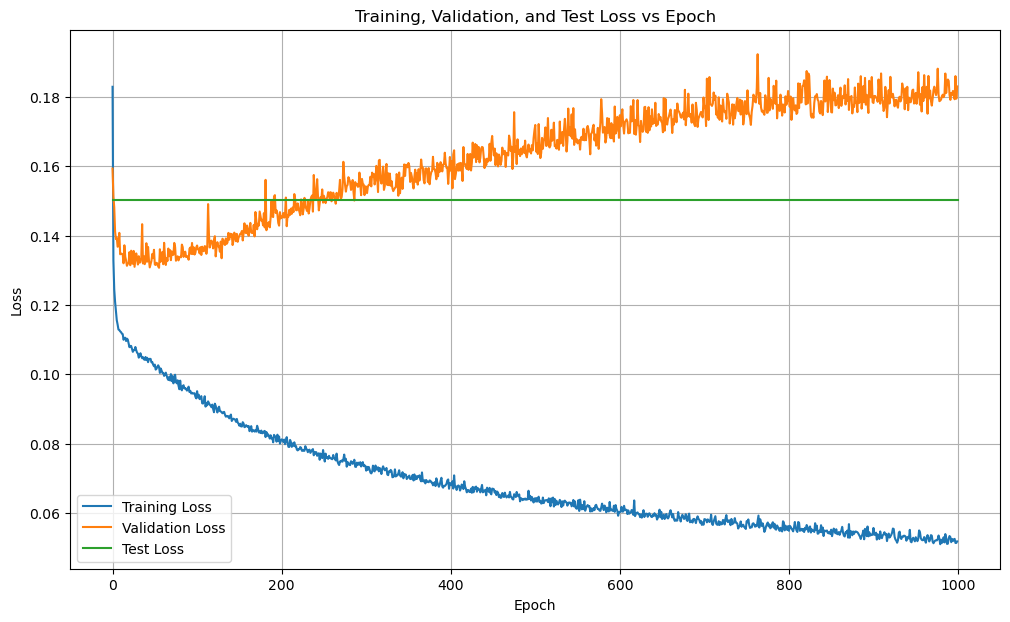

In [22]:
visualize_loss(history, results)

<div style="text-align: center;">
    Fig. 8.3. Training, Validation, and Test Loss vs Epoch.
</div>

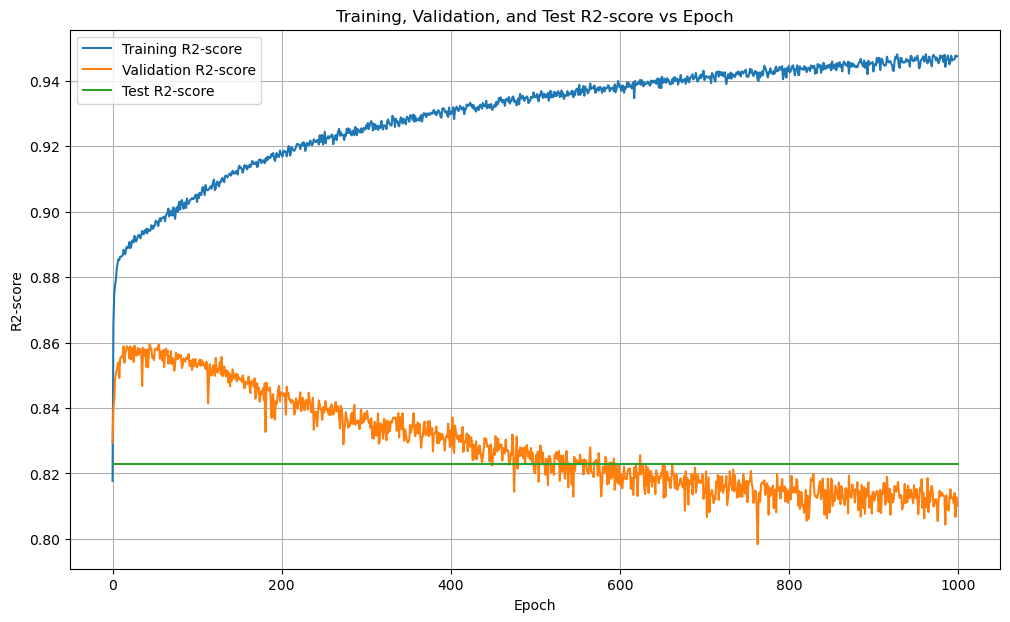

In [23]:
visualize_r2_score(history, results)

<div style="text-align: center;">
    Fig. 8.4. Training, Validation, and Test R2-score vs Epoch.
</div>

The final R2-score:

In [24]:
r2_score_dict[f"{model_name}"] = {
        "r2_score_train": round(history.history["r2_score"][-1], 4), 
        "r2_score_val": round(history.history["val_r2_score"][-1], 4), 
        "r2_score_test": round(results[4], 4)
}

In [25]:
r2_score_dict[f"{model_name}"]

{'r2_score_train': 0.9475, 'r2_score_val': 0.8101, 'r2_score_test': 0.823}

## 1 Layer + Dropout

### Build, Train and Evaluate the Model

Build the model:

In [26]:
def build_model(input_shape, model_name):
    # Set architecture.
    """Builds the model."""
    model = Sequential(
        [
            Input(shape=(x_train.shape[1],), name="L1_Input_Layer"), 
            Dense(128, activation="relu", name="L2_Hidden_Layer_1"), 
            Dropout(0.2),
            Dense(1, name="L3_Output_Layer")
        ],
        name=model_name
    )
    return model

Run the functions:

In [27]:
model_name = "one_layer_128_dropout"
# Build the model.
model = build_model((x_train.shape[1],), model_name)
# Configure the model.
compile_model(model)
# Save the model.
save_model(model, f"models/{model_name}")
# Train the model.
history = train_model(model)
# Save the history.
save_history(history, f"history/{model_name}.json")
# Evaluate the model.
results = model.evaluate(x_test, y_test)

Model: "one_layer_128_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L2_Hidden_Layer_1 (Dense)   (None, 128)               1408      
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 L3_Output_Layer (Dense)     (None, 1)                 129       
                                                                 
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: models/one_layer_128_dropout/assets


INFO:tensorflow:Assets written to: models/one_layer_128_dropout/assets


Epoch 1/1000
98/98 [==============================] - 1s 10ms/step - loss: 0.1924 - mean_absolute_error: 0.3077 - mean_squared_error: 0.1924 - root_mean_squared_error: 0.4387 - r2_score: 0.8062 - val_loss: 0.1589 - val_mean_absolute_error: 0.2634 - val_mean_squared_error: 0.1589 - val_root_mean_squared_error: 0.3987 - val_r2_score: 0.8316
Epoch 2/1000
98/98 [==============================] - 1s 8ms/step - loss: 0.1530 - mean_absolute_error: 0.2733 - mean_squared_error: 0.1530 - root_mean_squared_error: 0.3912 - r2_score: 0.8456 - val_loss: 0.1531 - val_mean_absolute_error: 0.2586 - val_mean_squared_error: 0.1531 - val_root_mean_squared_error: 0.3912 - val_r2_score: 0.8367
Epoch 3/1000
98/98 [==============================] - 1s 11ms/step - loss: 0.1456 - mean_absolute_error: 0.2667 - mean_squared_error: 0.1456 - root_mean_squared_error: 0.3816 - r2_score: 0.8526 - val_loss: 0.1479 - val_mean_absolute_error: 0.2567 - val_mean_squared_error: 0.1479 - val_root_mean_squared_error: 0.3846 -

### Visualize the results

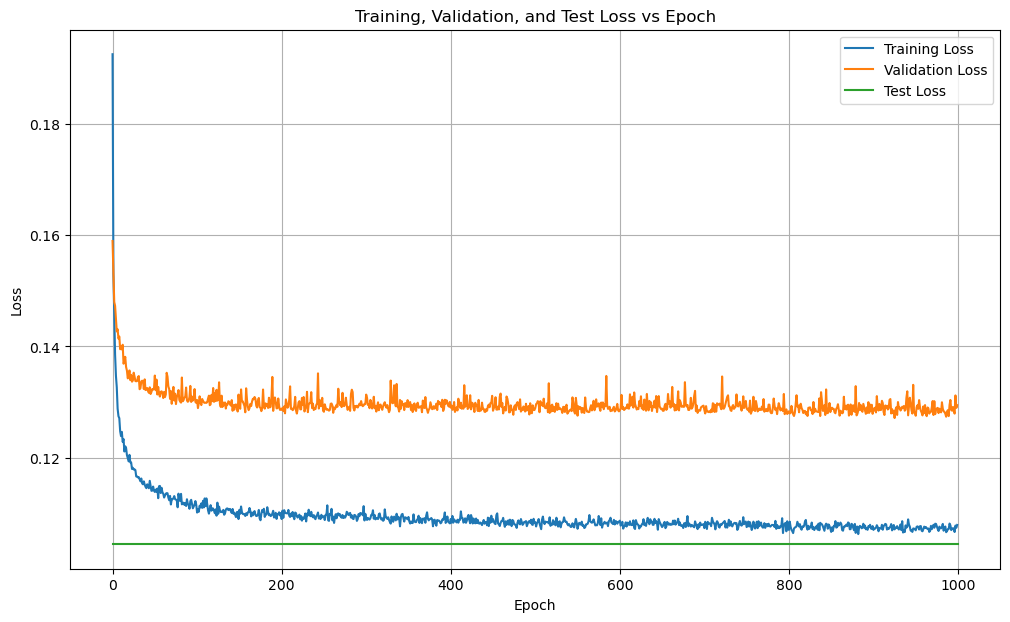

In [28]:
visualize_loss(history, results)

<div style="text-align: center;">
    Fig. 8.5. Training, Validation, and Test Loss vs Epoch.
</div>

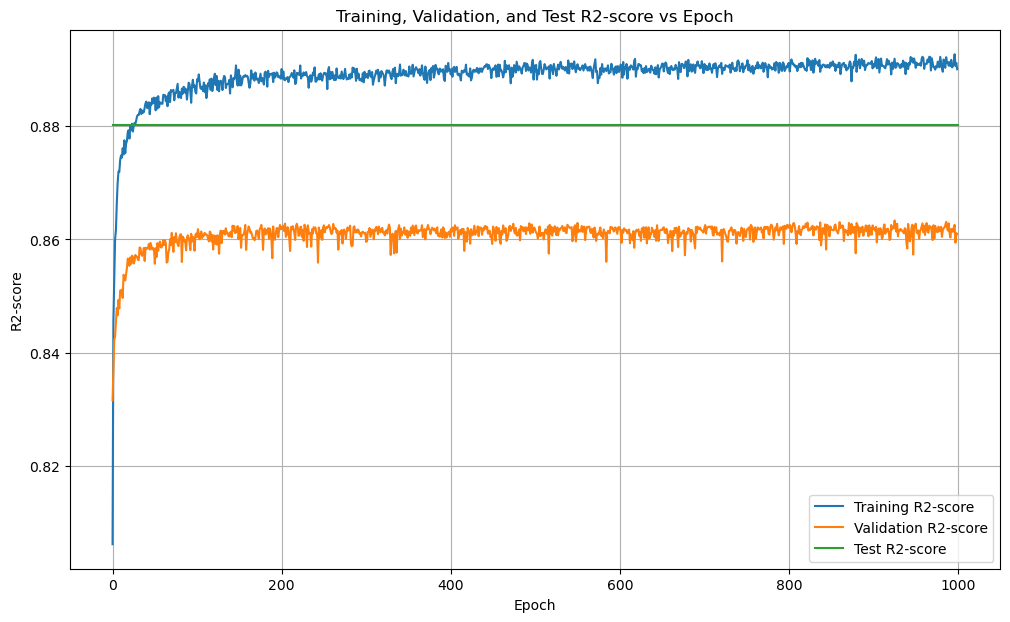

In [29]:
visualize_r2_score(history, results)

<div style="text-align: center;">
    Fig. 8.6. Training, Validation, and Test R2-score vs Epoch.
</div>

The final R2-score:

In [30]:
r2_score_dict[f"{model_name}"] = {
        "r2_score_train": round(history.history["r2_score"][-1], 4), 
        "r2_score_val": round(history.history["val_r2_score"][-1], 4), 
        "r2_score_test": round(results[4], 4)
}

In [31]:
r2_score_dict[f"{model_name}"]

{'r2_score_train': 0.89, 'r2_score_val': 0.861, 'r2_score_test': 0.8801}

## 2 Layers +  Dropout

### Build, Train and Evaluate the Model

Build the model:

In [32]:
def build_model(input_shape, model_name):
    """Builds the model."""
    model = Sequential(
        [
            Input(shape=(x_train.shape[1],), name="L1_Input_Layer"), 
            Dense(128, activation="relu", name="L2_Hidden_Layer_1"), 
            Dropout(0.2),
            Dense(64, activation="relu", name="L3_Hidden_Layer_2"), 
            Dropout(0.2),
            Dense(1, name="L4_Output_Layer")
        ],
        name=model_name
    )
    return model

Run the functions:

In [33]:
model_name = "two_layers_128_64_dropout"
# Build the model.
model = build_model((x_train.shape[1],), model_name)
# Configure the model.
compile_model(model)
# Save the model.
save_model(model, f"models/{model_name}")
# Train the model.
history = train_model(model)
# Save the history.
save_history(history, f"history/{model_name}.json")
# Evaluate the model.
results = model.evaluate(x_test, y_test)

Model: "two_layers_128_64_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L2_Hidden_Layer_1 (Dense)   (None, 128)               1408      
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 L3_Hidden_Layer_2 (Dense)   (None, 64)                8256      
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 L4_Output_Layer (Dense)     (None, 1)                 65        
                                                                 
Total params: 9729 (38.00 KB)
Trainable params: 9729 (38.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:te

INFO:tensorflow:Assets written to: models/two_layers_128_64_dropout/assets


Epoch 1/1000
98/98 [==============================] - 1s 11ms/step - loss: 0.2678 - mean_absolute_error: 0.3477 - mean_squared_error: 0.2678 - root_mean_squared_error: 0.5175 - r2_score: 0.7292 - val_loss: 0.1672 - val_mean_absolute_error: 0.2873 - val_mean_squared_error: 0.1672 - val_root_mean_squared_error: 0.4089 - val_r2_score: 0.8235
Epoch 2/1000
98/98 [==============================] - 1s 9ms/step - loss: 0.1595 - mean_absolute_error: 0.2803 - mean_squared_error: 0.1595 - root_mean_squared_error: 0.3994 - r2_score: 0.8407 - val_loss: 0.1662 - val_mean_absolute_error: 0.2910 - val_mean_squared_error: 0.1662 - val_root_mean_squared_error: 0.4077 - val_r2_score: 0.8257
Epoch 3/1000
98/98 [==============================] - 1s 12ms/step - loss: 0.1483 - mean_absolute_error: 0.2704 - mean_squared_error: 0.1483 - root_mean_squared_error: 0.3851 - r2_score: 0.8509 - val_loss: 0.1549 - val_mean_absolute_error: 0.2745 - val_mean_squared_error: 0.1549 - val_root_mean_squared_error: 0.3936 -

### Visualize the results

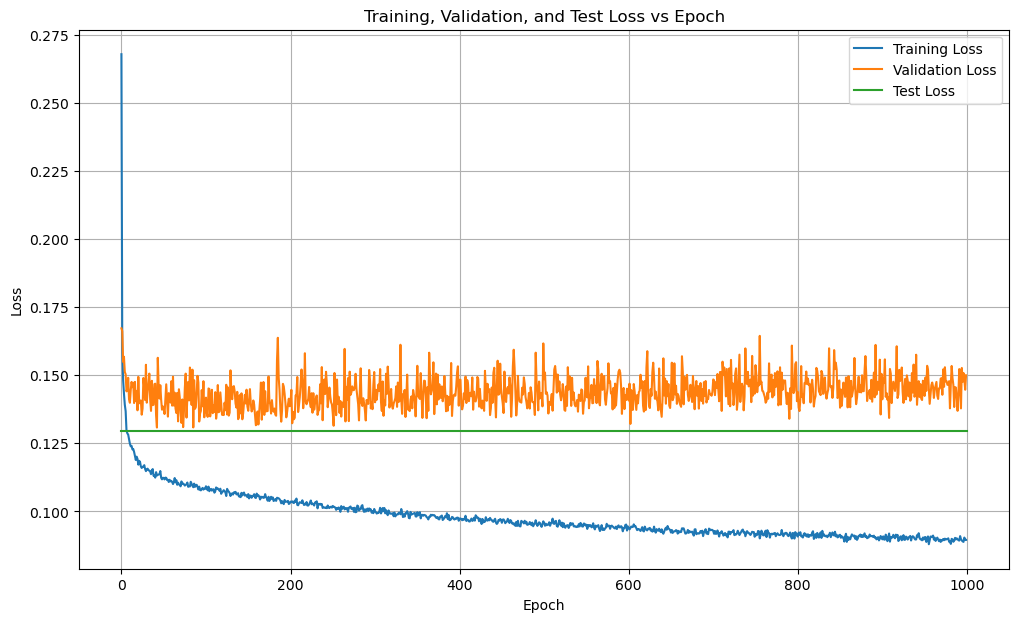

In [34]:
visualize_loss(history, results)

<div style="text-align: center;">
    Fig. 8.7. Training, Validation, and Test Loss vs Epoch.
</div>

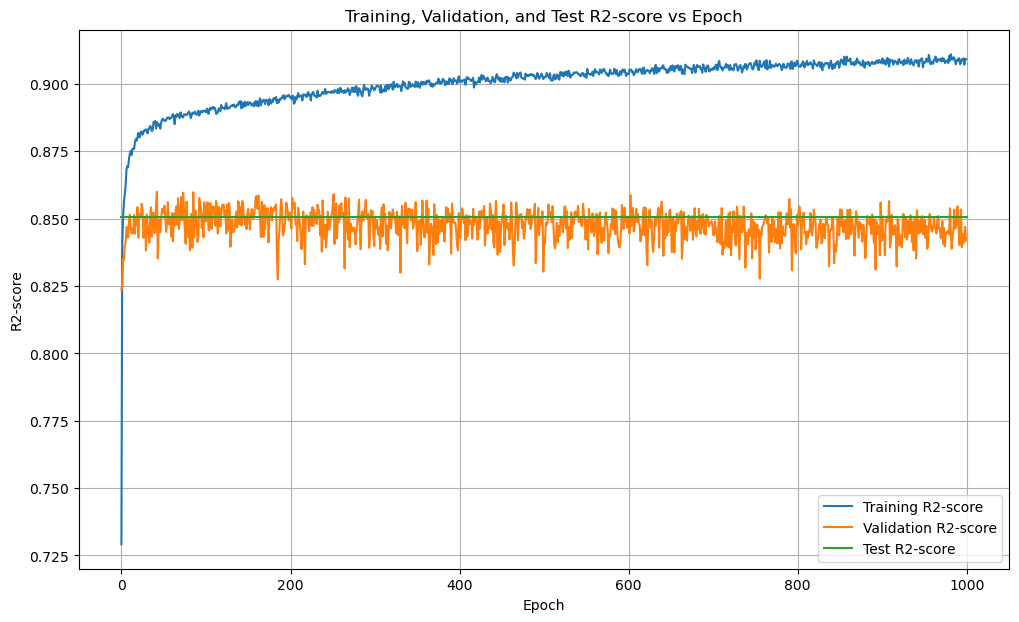

In [35]:
visualize_r2_score(history, results)

<div style="text-align: center;">
    Fig. 8.8. Training, Validation, and Test R2-score vs Epoch.
</div>

The final R2-score:

In [36]:
r2_score_dict[f"{model_name}"] = {
        "r2_score_train": round(history.history["r2_score"][-1], 4), 
        "r2_score_val": round(history.history["val_r2_score"][-1], 4), 
        "r2_score_test": round(results[4], 4)
}

In [37]:
r2_score_dict[f"{model_name}"]

{'r2_score_train': 0.9092, 'r2_score_val': 0.8419, 'r2_score_test': 0.8506}

In [38]:
r2_score_dict

{'one_layer_128': {'r2_score_train': 0.9023,
  'r2_score_val': 0.8554,
  'r2_score_test': 0.8668},
 'two_layers_128_64': {'r2_score_train': 0.9475,
  'r2_score_val': 0.8101,
  'r2_score_test': 0.823},
 'one_layer_128_dropout': {'r2_score_train': 0.89,
  'r2_score_val': 0.861,
  'r2_score_test': 0.8801},
 'two_layers_128_64_dropout': {'r2_score_train': 0.9092,
  'r2_score_val': 0.8419,
  'r2_score_test': 0.8506}}

## 1 Layer + Regularization (0.01)

### Build, Train and Evaluate the Model

Build the model:

In [39]:
def build_model(input_shape, model_name):
    # Set architecture.
    """Builds the model."""
    model = Sequential(
        [
            Input(shape=(x_train.shape[1],), name="L1_Input_Layer"), 
            Dense(128, activation="relu", name="L2_Hidden_Layer_1", kernel_regularizer=l2(0.01)), 
            #Dropout(0.2),
            Dense(1, name="L3_Output_Layer")
        ],
        name=model_name
    )
    return model

Run the functions:

In [40]:
model_name = "one_layer_128_reg_l2_0.01"
# Build the model.
model = build_model((x_train.shape[1],), model_name)
# Configure the model.
compile_model(model)
# Save the model.
save_model(model, f"models/{model_name}")
# Train the model.
history = train_model(model)
# Save the history.
save_history(history, f"history/{model_name}.json")
# Evaluate the model.
results = model.evaluate(x_test, y_test)

Model: "one_layer_128_reg_l2_0.01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L2_Hidden_Layer_1 (Dense)   (None, 128)               1408      
                                                                 
 L3_Output_Layer (Dense)     (None, 1)                 129       
                                                                 
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: models/one_layer_128_reg_l2_0.01/assets


INFO:tensorflow:Assets written to: models/one_layer_128_reg_l2_0.01/assets


Epoch 1/1000
98/98 [==============================] - 2s 14ms/step - loss: 0.3683 - mean_absolute_error: 0.3119 - mean_squared_error: 0.2038 - root_mean_squared_error: 0.4515 - r2_score: 0.7914 - val_loss: 0.3103 - val_mean_absolute_error: 0.2809 - val_mean_squared_error: 0.1667 - val_root_mean_squared_error: 0.4083 - val_r2_score: 0.8222
Epoch 2/1000
98/98 [==============================] - 1s 10ms/step - loss: 0.2649 - mean_absolute_error: 0.2620 - mean_squared_error: 0.1402 - root_mean_squared_error: 0.3744 - r2_score: 0.8586 - val_loss: 0.2642 - val_mean_absolute_error: 0.2659 - val_mean_squared_error: 0.1575 - val_root_mean_squared_error: 0.3968 - val_r2_score: 0.8320
Epoch 3/1000
98/98 [==============================] - 1s 15ms/step - loss: 0.2253 - mean_absolute_error: 0.2535 - mean_squared_error: 0.1329 - root_mean_squared_error: 0.3646 - r2_score: 0.8657 - val_loss: 0.2323 - val_mean_absolute_error: 0.2602 - val_mean_squared_error: 0.1532 - val_root_mean_squared_error: 0.3914 

### Visualize the results

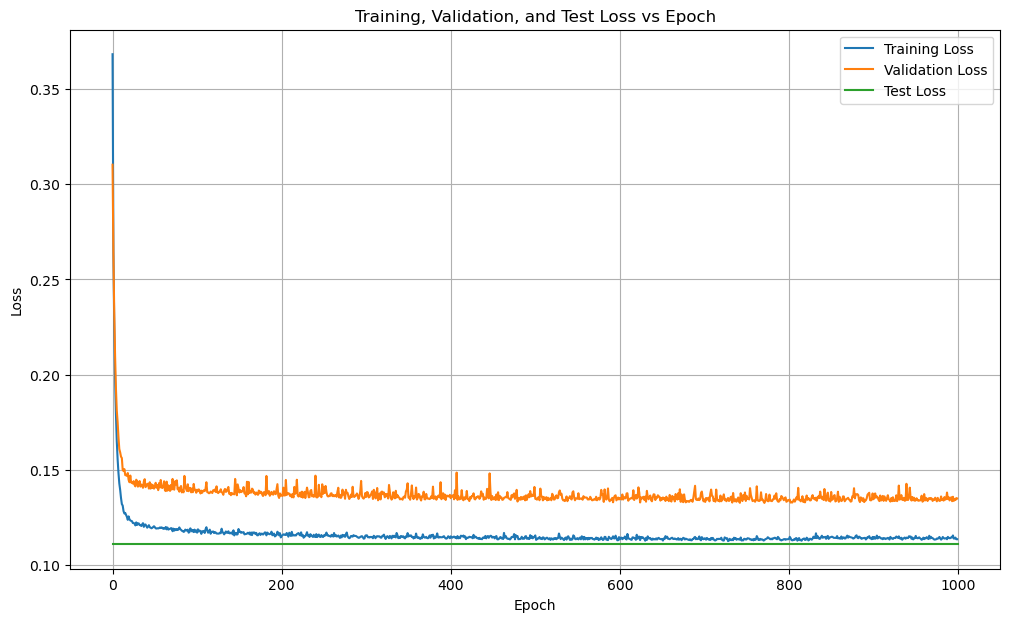

In [41]:
visualize_loss(history, results)

<div style="text-align: center;">
    Fig. 8.9. Training, Validation, and Test Loss vs Epoch.
</div>

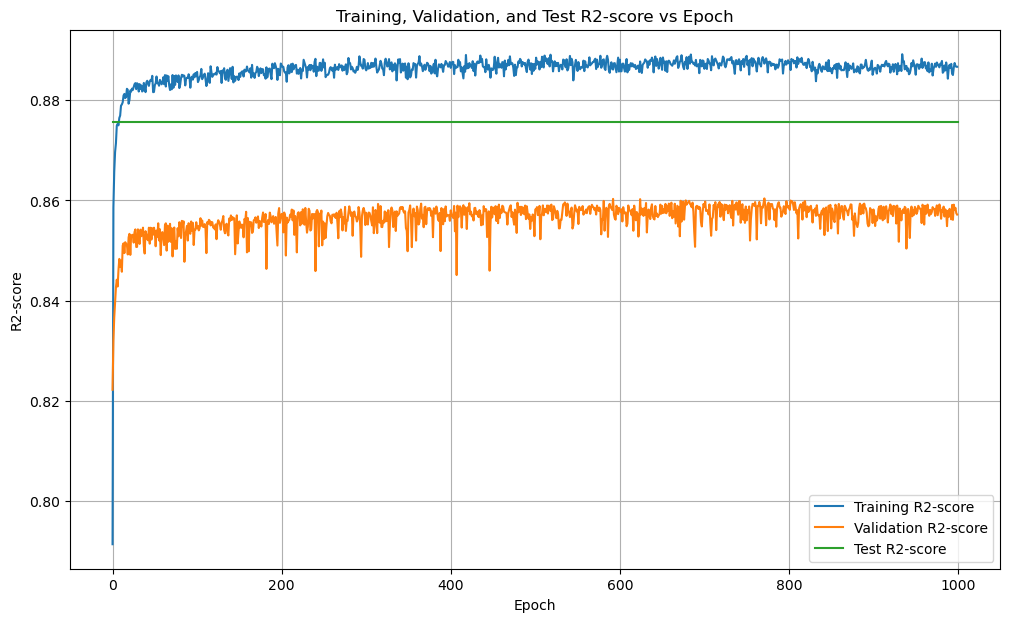

In [42]:
visualize_r2_score(history, results)

<div style="text-align: center;">
    Fig. 8.10. Training, Validation, and Test R2-score vs Epoch.
</div>

The final R2-score:

In [43]:
r2_score_dict[f"{model_name}"] = {
        "r2_score_train": round(history.history["r2_score"][-1], 4), 
        "r2_score_val": round(history.history["val_r2_score"][-1], 4), 
        "r2_score_test": round(results[4], 4)
}

In [44]:
r2_score_dict[f"{model_name}"]

{'r2_score_train': 0.8867, 'r2_score_val': 0.8572, 'r2_score_test': 0.8757}

In [45]:
r2_score_dict

{'one_layer_128': {'r2_score_train': 0.9023,
  'r2_score_val': 0.8554,
  'r2_score_test': 0.8668},
 'two_layers_128_64': {'r2_score_train': 0.9475,
  'r2_score_val': 0.8101,
  'r2_score_test': 0.823},
 'one_layer_128_dropout': {'r2_score_train': 0.89,
  'r2_score_val': 0.861,
  'r2_score_test': 0.8801},
 'two_layers_128_64_dropout': {'r2_score_train': 0.9092,
  'r2_score_val': 0.8419,
  'r2_score_test': 0.8506},
 'one_layer_128_reg_l2_0.01': {'r2_score_train': 0.8867,
  'r2_score_val': 0.8572,
  'r2_score_test': 0.8757}}

## 1 Layer + Regularization (0.02)

### Build, Train and Evaluate the Model

Build the model:

In [46]:
def build_model(input_shape, model_name):
    # Set architecture.
    """Builds the model."""
    model = Sequential(
        [
            Input(shape=(x_train.shape[1],), name="L1_Input_Layer"), 
            Dense(128, activation="relu", name="L2_Hidden_Layer_1", kernel_regularizer=l2(0.02)), 
            #Dropout(0.2),
            Dense(1, name="L3_Output_Layer")
        ],
        name=model_name
    )
    return model

Run the functions:

In [47]:
model_name = "one_layer_128_reg_l2_0.02"
# Build the model.
model = build_model((x_train.shape[1],), model_name)
# Configure the model.
compile_model(model)
# Save the model.
save_model(model, f"models/{model_name}")
# Train the model.
history = train_model(model)
# Save the history.
save_history(history, f"history/{model_name}.json")
# Evaluate the model.
results = model.evaluate(x_test, y_test)

Model: "one_layer_128_reg_l2_0.02"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L2_Hidden_Layer_1 (Dense)   (None, 128)               1408      
                                                                 
 L3_Output_Layer (Dense)     (None, 1)                 129       
                                                                 
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: models/one_layer_128_reg_l2_0.02/assets


INFO:tensorflow:Assets written to: models/one_layer_128_reg_l2_0.02/assets


Epoch 1/1000
98/98 [==============================] - 2s 15ms/step - loss: 0.4347 - mean_absolute_error: 0.2710 - mean_squared_error: 0.1503 - root_mean_squared_error: 0.3877 - r2_score: 0.8481 - val_loss: 0.3581 - val_mean_absolute_error: 0.2740 - val_mean_squared_error: 0.1629 - val_root_mean_squared_error: 0.4036 - val_r2_score: 0.8264
Epoch 2/1000
98/98 [==============================] - 1s 10ms/step - loss: 0.2738 - mean_absolute_error: 0.2540 - mean_squared_error: 0.1336 - root_mean_squared_error: 0.3655 - r2_score: 0.8638 - val_loss: 0.2501 - val_mean_absolute_error: 0.2676 - val_mean_squared_error: 0.1544 - val_root_mean_squared_error: 0.3930 - val_r2_score: 0.8351
Epoch 3/1000
98/98 [==============================] - 1s 10ms/step - loss: 0.2007 - mean_absolute_error: 0.2505 - mean_squared_error: 0.1303 - root_mean_squared_error: 0.3610 - r2_score: 0.8674 - val_loss: 0.2014 - val_mean_absolute_error: 0.2582 - val_mean_squared_error: 0.1513 - val_root_mean_squared_error: 0.3890 

### Visualize the results

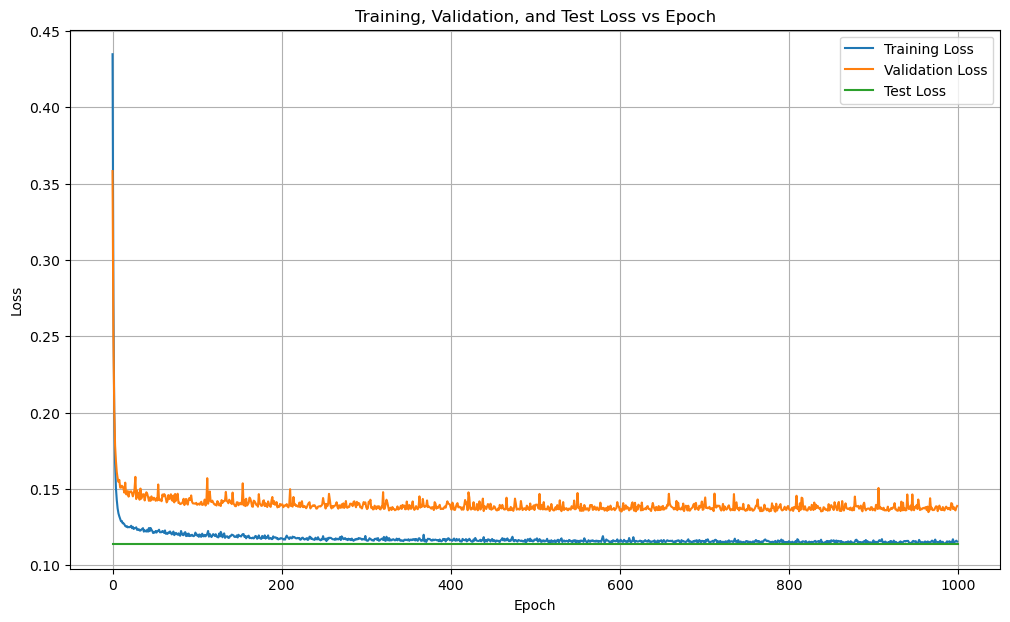

In [48]:
visualize_loss(history, results)

<div style="text-align: center;">
    Fig. 8.11. Training, Validation, and Test Loss vs Epoch.
</div>

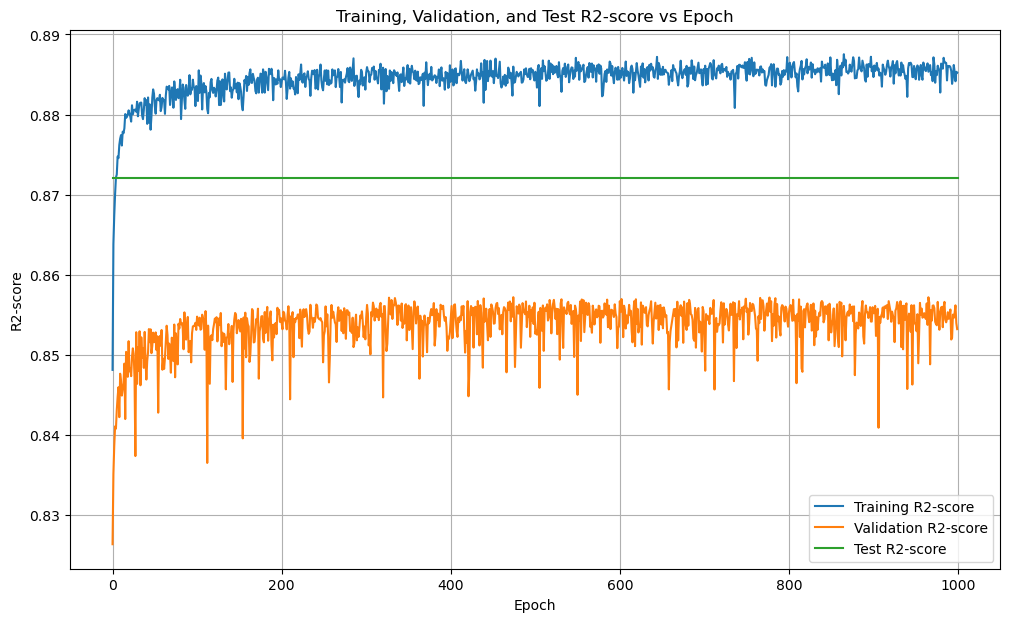

In [49]:
visualize_r2_score(history, results)

<div style="text-align: center;">
    Fig. 8.12. Training, Validation, and Test R2-score vs Epoch.
</div>

The final R2-score:

In [50]:
r2_score_dict[f"{model_name}"] = {
        "r2_score_train": round(history.history["r2_score"][-1], 4), 
        "r2_score_val": round(history.history["val_r2_score"][-1], 4), 
        "r2_score_test": round(results[4], 4)
}

In [51]:
r2_score_dict[f"{model_name}"]

{'r2_score_train': 0.8852, 'r2_score_val': 0.8532, 'r2_score_test': 0.8721}

In [52]:
r2_score_dict

{'one_layer_128': {'r2_score_train': 0.9023,
  'r2_score_val': 0.8554,
  'r2_score_test': 0.8668},
 'two_layers_128_64': {'r2_score_train': 0.9475,
  'r2_score_val': 0.8101,
  'r2_score_test': 0.823},
 'one_layer_128_dropout': {'r2_score_train': 0.89,
  'r2_score_val': 0.861,
  'r2_score_test': 0.8801},
 'two_layers_128_64_dropout': {'r2_score_train': 0.9092,
  'r2_score_val': 0.8419,
  'r2_score_test': 0.8506},
 'one_layer_128_reg_l2_0.01': {'r2_score_train': 0.8867,
  'r2_score_val': 0.8572,
  'r2_score_test': 0.8757},
 'one_layer_128_reg_l2_0.02': {'r2_score_train': 0.8852,
  'r2_score_val': 0.8532,
  'r2_score_test': 0.8721}}

## 1 Layer + Regularization (1)

### Build, Train and Evaluate the Model

Build the model:

In [53]:
def build_model(input_shape, model_name):
    # Set architecture.
    """Builds the model."""
    model = Sequential(
        [
            Input(shape=(x_train.shape[1],), name="L1_Input_Layer"), 
            Dense(128, activation="relu", name="L2_Hidden_Layer_1", kernel_regularizer=l2(1)), 
            #Dropout(0.2),
            Dense(1, name="L3_Output_Layer")
        ],
        name=model_name
    )
    return model

Run the functions:

In [54]:
model_name = "one_layer_128_reg_l2_1"
# Build the model.
model = build_model((x_train.shape[1],), model_name)
# Configure the model.
compile_model(model)
# Save the model.
save_model(model, f"models/{model_name}")
# Train the model.
history = train_model(model)
# Save the history.
save_history(history, f"history/{model_name}.json")
# Evaluate the model.
results = model.evaluate(x_test, y_test)

Model: "one_layer_128_reg_l2_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L2_Hidden_Layer_1 (Dense)   (None, 128)               1408      
                                                                 
 L3_Output_Layer (Dense)     (None, 1)                 129       
                                                                 
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: models/one_layer_128_reg_l2_1/assets


INFO:tensorflow:Assets written to: models/one_layer_128_reg_l2_1/assets


Epoch 1/1000
98/98 [==============================] - 1s 12ms/step - loss: 10.2217 - mean_absolute_error: 0.3950 - mean_squared_error: 0.3168 - root_mean_squared_error: 0.5629 - r2_score: 0.6884 - val_loss: 4.0966 - val_mean_absolute_error: 0.3187 - val_mean_squared_error: 0.2015 - val_root_mean_squared_error: 0.4489 - val_r2_score: 0.7912
Epoch 2/1000
98/98 [==============================] - 1s 13ms/step - loss: 2.0053 - mean_absolute_error: 0.2904 - mean_squared_error: 0.1634 - root_mean_squared_error: 0.4043 - r2_score: 0.8353 - val_loss: 0.7965 - val_mean_absolute_error: 0.2815 - val_mean_squared_error: 0.1717 - val_root_mean_squared_error: 0.4143 - val_r2_score: 0.8189
Epoch 3/1000
98/98 [==============================] - 1s 10ms/step - loss: 0.4343 - mean_absolute_error: 0.2758 - mean_squared_error: 0.1488 - root_mean_squared_error: 0.3858 - r2_score: 0.8508 - val_loss: 0.2730 - val_mean_absolute_error: 0.2791 - val_mean_squared_error: 0.1676 - val_root_mean_squared_error: 0.4094

### Visualize the results

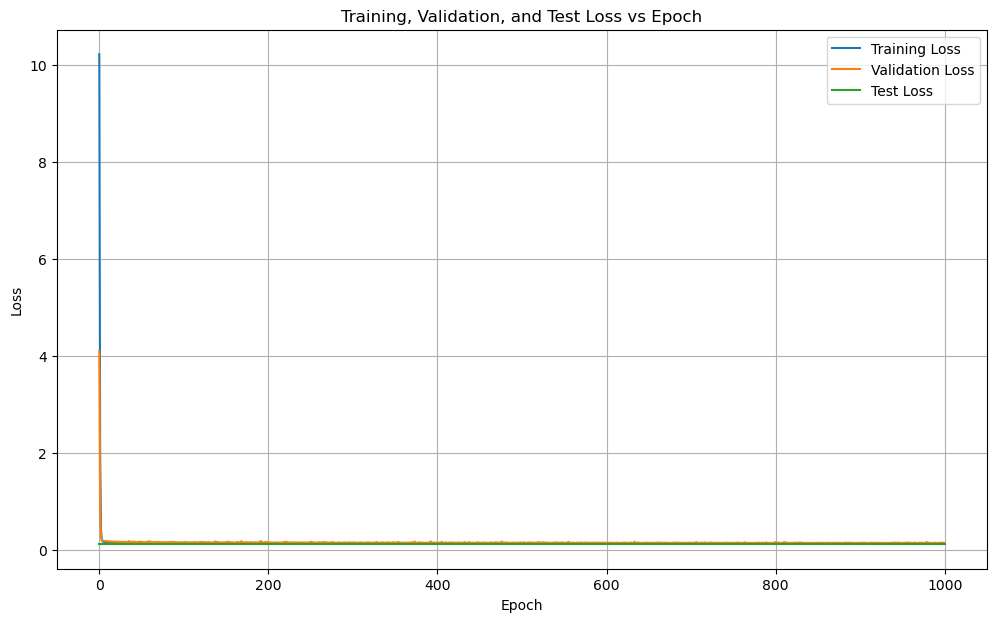

In [55]:
visualize_loss(history, results)

<div style="text-align: center;">
    Fig. 8.13. Training, Validation, and Test Loss vs Epoch.
</div>

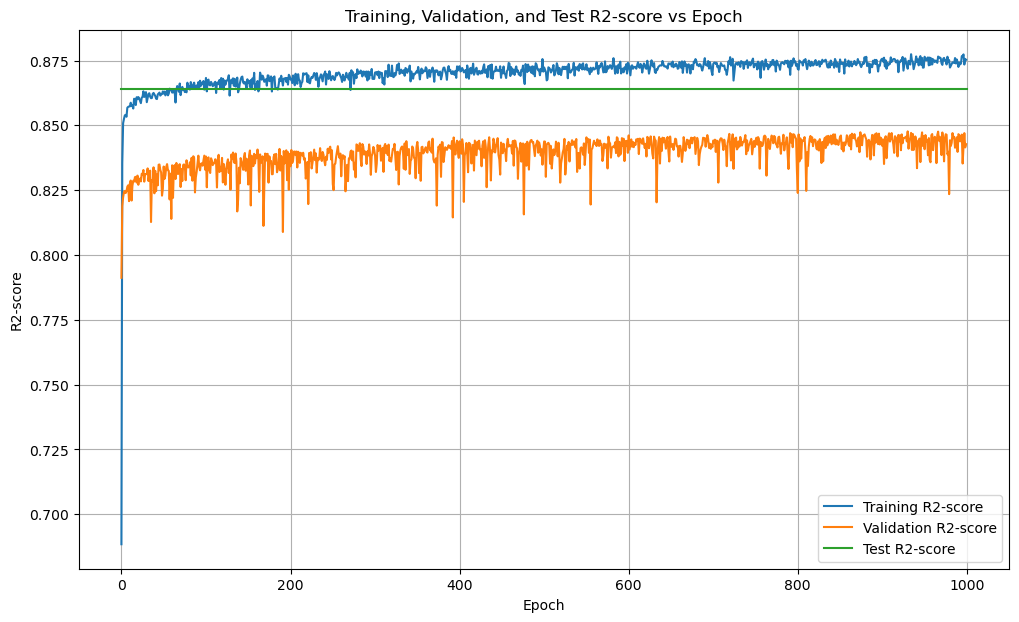

In [56]:
visualize_r2_score(history, results)

<div style="text-align: center;">
    Fig. 8.14. Training, Validation, and Test R2-score vs Epoch.
</div>

The final R2-score:

In [57]:
r2_score_dict[f"{model_name}"] = {
        "r2_score_train": round(history.history["r2_score"][-1], 4), 
        "r2_score_val": round(history.history["val_r2_score"][-1], 4), 
        "r2_score_test": round(results[4], 4)
}

In [58]:
r2_score_dict[f"{model_name}"]

{'r2_score_train': 0.8753, 'r2_score_val': 0.8427, 'r2_score_test': 0.864}

In [59]:
r2_score_dict

{'one_layer_128': {'r2_score_train': 0.9023,
  'r2_score_val': 0.8554,
  'r2_score_test': 0.8668},
 'two_layers_128_64': {'r2_score_train': 0.9475,
  'r2_score_val': 0.8101,
  'r2_score_test': 0.823},
 'one_layer_128_dropout': {'r2_score_train': 0.89,
  'r2_score_val': 0.861,
  'r2_score_test': 0.8801},
 'two_layers_128_64_dropout': {'r2_score_train': 0.9092,
  'r2_score_val': 0.8419,
  'r2_score_test': 0.8506},
 'one_layer_128_reg_l2_0.01': {'r2_score_train': 0.8867,
  'r2_score_val': 0.8572,
  'r2_score_test': 0.8757},
 'one_layer_128_reg_l2_0.02': {'r2_score_train': 0.8852,
  'r2_score_val': 0.8532,
  'r2_score_test': 0.8721},
 'one_layer_128_reg_l2_1': {'r2_score_train': 0.8753,
  'r2_score_val': 0.8427,
  'r2_score_test': 0.864}}

## 2 Layers + Regularization (0.01)

### Build, Train and Evaluate the Model

Build the model:

In [60]:
def build_model(input_shape, model_name):
    """Builds the model."""
    model = Sequential(
        [
            Input(shape=(x_train.shape[1],), name="L1_Input_Layer"), 
            Dense(128, activation="relu", name="L2_Hidden_Layer_1", kernel_regularizer=l2(0.01)), 
            #Dropout(0.2),
            Dense(64, activation="relu", name="L3_Hidden_Layer_2", kernel_regularizer=l2(0.01)), 
            #Dropout(0.2),
            Dense(1, name="L4_Output_Layer")
        ],
        name=model_name
    )
    return model

Run the functions:

In [61]:
model_name = "two_layers_128_64_reg_l2_0.01"
# Build the model.
model = build_model((x_train.shape[1],), model_name)
# Configure the model.
compile_model(model)
# Save the model.
save_model(model, f"models/{model_name}")
# Train the model.
history = train_model(model)
# Save the history.
save_history(history, f"history/{model_name}.json")
# Evaluate the model.
results = model.evaluate(x_test, y_test)

Model: "two_layers_128_64_reg_l2_0.01"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L2_Hidden_Layer_1 (Dense)   (None, 128)               1408      
                                                                 
 L3_Hidden_Layer_2 (Dense)   (None, 64)                8256      
                                                                 
 L4_Output_Layer (Dense)     (None, 1)                 65        
                                                                 
Total params: 9729 (38.00 KB)
Trainable params: 9729 (38.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: models/two_layers_128_64_reg_l2_0.01/assets


INFO:tensorflow:Assets written to: models/two_layers_128_64_reg_l2_0.01/assets


Epoch 1/1000
98/98 [==============================] - 2s 16ms/step - loss: 0.9751 - mean_absolute_error: 0.2991 - mean_squared_error: 0.1958 - root_mean_squared_error: 0.4424 - r2_score: 0.7998 - val_loss: 0.6919 - val_mean_absolute_error: 0.2759 - val_mean_squared_error: 0.1611 - val_root_mean_squared_error: 0.4014 - val_r2_score: 0.8286
Epoch 2/1000
98/98 [==============================] - 2s 15ms/step - loss: 0.5281 - mean_absolute_error: 0.2535 - mean_squared_error: 0.1328 - root_mean_squared_error: 0.3644 - r2_score: 0.8657 - val_loss: 0.4420 - val_mean_absolute_error: 0.2617 - val_mean_squared_error: 0.1529 - val_root_mean_squared_error: 0.3910 - val_r2_score: 0.8373
Epoch 3/1000
98/98 [==============================] - 1s 13ms/step - loss: 0.3576 - mean_absolute_error: 0.2490 - mean_squared_error: 0.1291 - root_mean_squared_error: 0.3593 - r2_score: 0.8697 - val_loss: 0.3287 - val_mean_absolute_error: 0.2629 - val_mean_squared_error: 0.1502 - val_root_mean_squared_error: 0.3876 

### Visualize the results

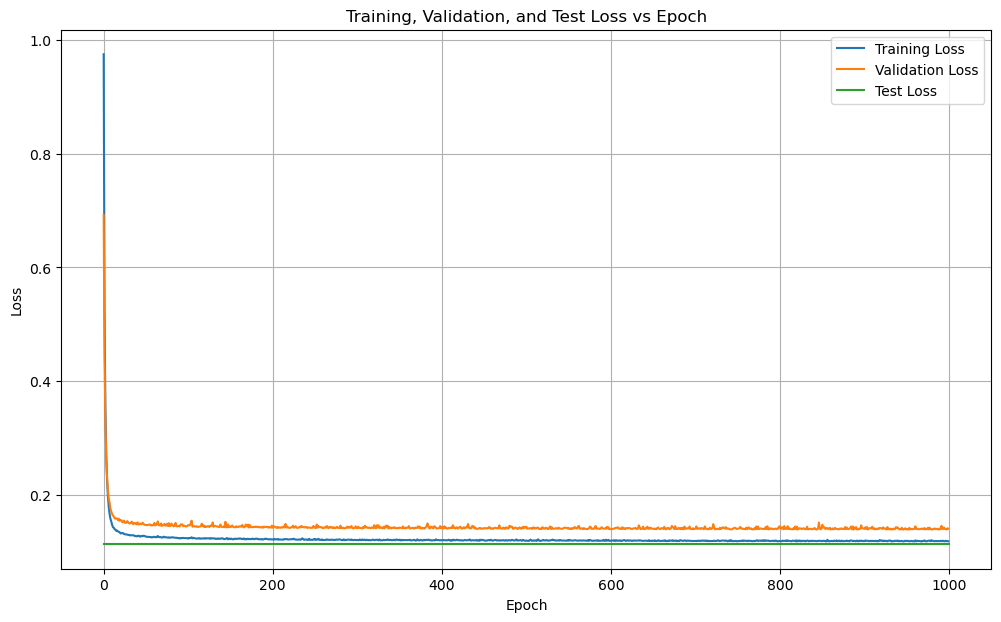

In [62]:
visualize_loss(history, results)

<div style="text-align: center;">
    Fig. 8.15. Training, Validation, and Test Loss vs Epoch.
</div>

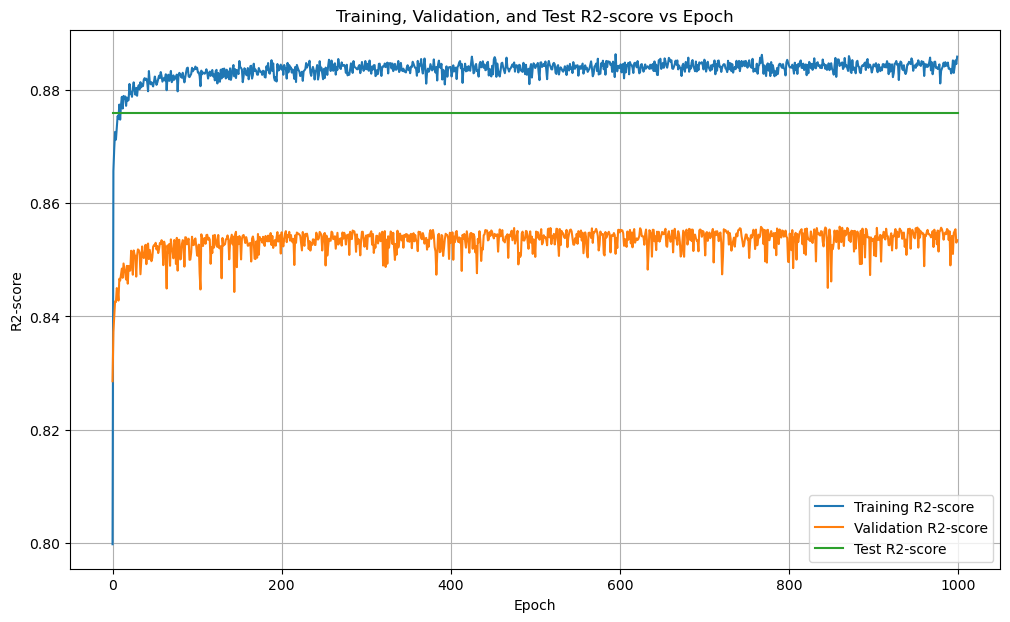

In [63]:
visualize_r2_score(history, results)

<div style="text-align: center;">
    Fig. 8.16. Training, Validation, and Test R2-score vs Epoch.
</div>

The final R2-score:

In [64]:
r2_score_dict[f"{model_name}"] = {
        "r2_score_train": round(history.history["r2_score"][-1], 4), 
        "r2_score_val": round(history.history["val_r2_score"][-1], 4), 
        "r2_score_test": round(results[4], 4)
}

In [65]:
r2_score_dict[f"{model_name}"]

{'r2_score_train': 0.8859, 'r2_score_val': 0.8535, 'r2_score_test': 0.8758}

In [66]:
r2_score_dict

{'one_layer_128': {'r2_score_train': 0.9023,
  'r2_score_val': 0.8554,
  'r2_score_test': 0.8668},
 'two_layers_128_64': {'r2_score_train': 0.9475,
  'r2_score_val': 0.8101,
  'r2_score_test': 0.823},
 'one_layer_128_dropout': {'r2_score_train': 0.89,
  'r2_score_val': 0.861,
  'r2_score_test': 0.8801},
 'two_layers_128_64_dropout': {'r2_score_train': 0.9092,
  'r2_score_val': 0.8419,
  'r2_score_test': 0.8506},
 'one_layer_128_reg_l2_0.01': {'r2_score_train': 0.8867,
  'r2_score_val': 0.8572,
  'r2_score_test': 0.8757},
 'one_layer_128_reg_l2_0.02': {'r2_score_train': 0.8852,
  'r2_score_val': 0.8532,
  'r2_score_test': 0.8721},
 'one_layer_128_reg_l2_1': {'r2_score_train': 0.8753,
  'r2_score_val': 0.8427,
  'r2_score_test': 0.864},
 'two_layers_128_64_reg_l2_0.01': {'r2_score_train': 0.8859,
  'r2_score_val': 0.8535,
  'r2_score_test': 0.8758}}

# 2 Layers + Regularization (1)

### Build, Train and Evaluate the Model

Build the model:

In [67]:
def build_model(input_shape, model_name):
    """Builds the model."""
    model = Sequential(
        [
            Input(shape=(x_train.shape[1],), name="L1_Input_Layer"), 
            Dense(128, activation="relu", name="L2_Hidden_Layer_1", kernel_regularizer=l2(1)), 
            #Dropout(0.2),
            Dense(64, activation="relu", name="L3_Hidden_Layer_2", kernel_regularizer=l2(1)), 
            #Dropout(0.2),
            Dense(1, name="L4_Output_Layer")
        ],
        name=model_name
    )
    return model

Run the functions:

In [68]:
model_name = "two_layers_128_64_reg_l2_1"
# Build the model.
model = build_model((x_train.shape[1],), model_name)
# Configure the model.
compile_model(model)
# Save the model.
save_model(model, f"models/{model_name}")
# Train the model.
history = train_model(model)
# Save the history.
save_history(history, f"history/{model_name}.json")
# Evaluate the model.
results = model.evaluate(x_test, y_test)

Model: "two_layers_128_64_reg_l2_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L2_Hidden_Layer_1 (Dense)   (None, 128)               1408      
                                                                 
 L3_Hidden_Layer_2 (Dense)   (None, 64)                8256      
                                                                 
 L4_Output_Layer (Dense)     (None, 1)                 65        
                                                                 
Total params: 9729 (38.00 KB)
Trainable params: 9729 (38.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: models/two_layers_128_64_reg_l2_1/assets


INFO:tensorflow:Assets written to: models/two_layers_128_64_reg_l2_1/assets


Epoch 1/1000
98/98 [==============================] - 2s 16ms/step - loss: 50.2875 - mean_absolute_error: 0.5458 - mean_squared_error: 0.5036 - root_mean_squared_error: 0.7096 - r2_score: 0.4999 - val_loss: 16.8821 - val_mean_absolute_error: 0.4279 - val_mean_squared_error: 0.3111 - val_root_mean_squared_error: 0.5578 - val_r2_score: 0.6868
Epoch 2/1000
98/98 [==============================] - 1s 15ms/step - loss: 7.3677 - mean_absolute_error: 0.3865 - mean_squared_error: 0.2544 - root_mean_squared_error: 0.5043 - r2_score: 0.7448 - val_loss: 2.2839 - val_mean_absolute_error: 0.3688 - val_mean_squared_error: 0.2419 - val_root_mean_squared_error: 0.4918 - val_r2_score: 0.7532
Epoch 3/1000
98/98 [==============================] - 1s 15ms/step - loss: 1.1313 - mean_absolute_error: 0.3441 - mean_squared_error: 0.2044 - root_mean_squared_error: 0.4521 - r2_score: 0.7935 - val_loss: 0.6090 - val_mean_absolute_error: 0.3373 - val_mean_squared_error: 0.2194 - val_root_mean_squared_error: 0.468

### Visualize the results

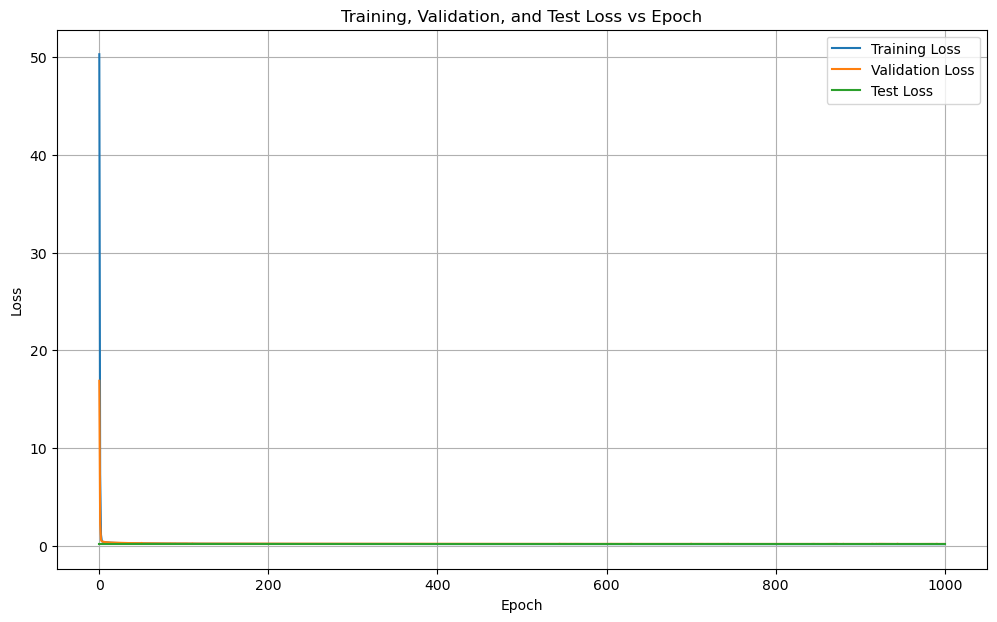

In [69]:
visualize_loss(history, results)

<div style="text-align: center;">
    Fig. 8.17. Training, Validation, and Test Loss vs Epoch.
</div>

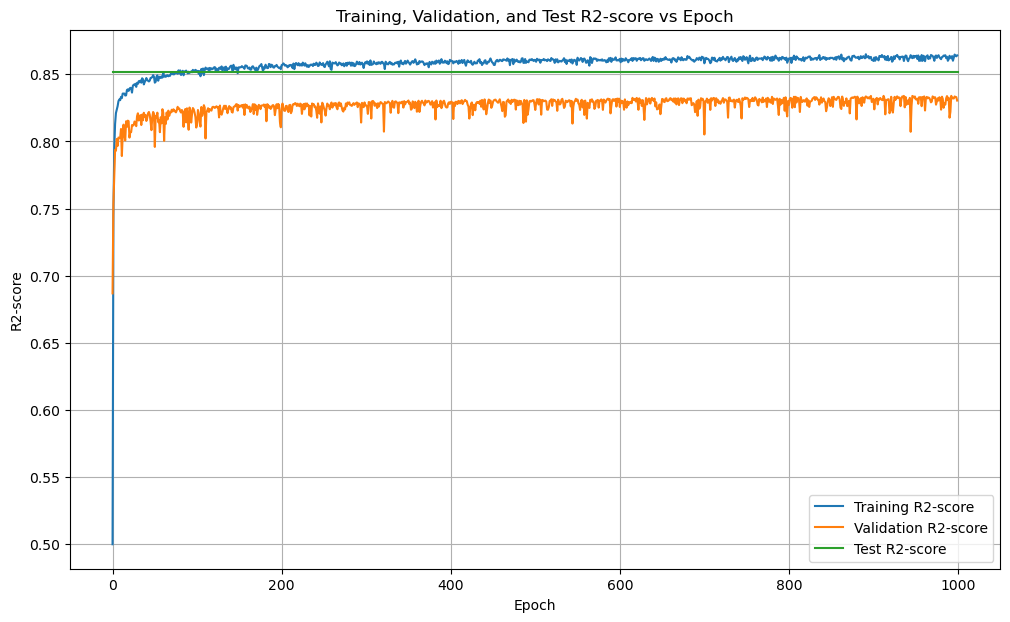

In [70]:
visualize_r2_score(history, results)

<div style="text-align: center;">
    Fig. 8.18. Training, Validation, and Test R2-score vs Epoch.
</div>

The final R2-score:

In [71]:
r2_score_dict[f"{model_name}"] = {
        "r2_score_train": round(history.history["r2_score"][-1], 4), 
        "r2_score_val": round(history.history["val_r2_score"][-1], 4), 
        "r2_score_test": round(results[4], 4)
}

In [72]:
r2_score_dict[f"{model_name}"]

{'r2_score_train': 0.8641, 'r2_score_val': 0.8304, 'r2_score_test': 0.8516}

In [73]:
r2_score_dict

{'one_layer_128': {'r2_score_train': 0.9023,
  'r2_score_val': 0.8554,
  'r2_score_test': 0.8668},
 'two_layers_128_64': {'r2_score_train': 0.9475,
  'r2_score_val': 0.8101,
  'r2_score_test': 0.823},
 'one_layer_128_dropout': {'r2_score_train': 0.89,
  'r2_score_val': 0.861,
  'r2_score_test': 0.8801},
 'two_layers_128_64_dropout': {'r2_score_train': 0.9092,
  'r2_score_val': 0.8419,
  'r2_score_test': 0.8506},
 'one_layer_128_reg_l2_0.01': {'r2_score_train': 0.8867,
  'r2_score_val': 0.8572,
  'r2_score_test': 0.8757},
 'one_layer_128_reg_l2_0.02': {'r2_score_train': 0.8852,
  'r2_score_val': 0.8532,
  'r2_score_test': 0.8721},
 'one_layer_128_reg_l2_1': {'r2_score_train': 0.8753,
  'r2_score_val': 0.8427,
  'r2_score_test': 0.864},
 'two_layers_128_64_reg_l2_0.01': {'r2_score_train': 0.8859,
  'r2_score_val': 0.8535,
  'r2_score_test': 0.8758},
 'two_layers_128_64_reg_l2_1': {'r2_score_train': 0.8641,
  'r2_score_val': 0.8304,
  'r2_score_test': 0.8516}}

## 1 Layer + Callbacks (EarlyStopping and ReduceLROnPlateau)

### Build, Train and Evaluate the Model

In [74]:
def set_early_stopping():
    es = EarlyStopping(
        monitor="val_loss",
        min_delta=0,
        patience=30,
        verbose=1,
        mode="auto",
        restore_best_weights=True
    )
    return es

In [75]:
def set_lr():
    rlr = ReduceLROnPlateau(
        monitor="val_loss", 
        factor=0.1, 
        patience=10, 
        verbose=1, 
        min_delta=1e-4, 
        in_lr=0.00001,
        mode="auto"
    )
    return rlr

Build the model:

In [76]:
def build_model(input_shape, model_name):
    # Set architecture.
    """Builds the model."""
    model = Sequential(
        [
            Input(shape=(x_train.shape[1],), name="L1_Input_Layer"), 
            Dense(128, activation="relu", name="L2_Hidden_Layer_1"), 
            Dense(1, name="L3_Output_Layer")
        ],
        name=model_name
    )
    return model

In [77]:
def train_model(model, callbacks):
    """Trains the model"""
    history = model.fit(
        x_train, y_train, 
        epochs=1000, 
        batch_size=128, 
        validation_data=(x_val, y_val),
        callbacks=callbacks
    )
    return history

Run the functions:

In [78]:
model_name = "one_layer_128_early_stopping_reduce_LR"
# Build the model.
model = build_model((x_train.shape[1],), model_name)
# Configure the model.
compile_model(model)
# Save the model.
save_model(model, f"models/{model_name}")
# Set the callbacks: EarlyStoppin, ReduceLROnPlateau
callbacks = [set_early_stopping(), set_lr()]
# callbacks = set_early_stopping()
# Train the model.
history = train_model(model, callbacks)
# Save the history.
save_history(history, f"history/{model_name}.json")
# Evaluate the model.
results = model.evaluate(x_test, y_test)

Model: "one_layer_128_early_stopping_reduce_LR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L2_Hidden_Layer_1 (Dense)   (None, 128)               1408      
                                                                 
 L3_Output_Layer (Dense)     (None, 1)                 129       
                                                                 
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: models/one_layer_128_early_stopping_reduce_LR/assets


INFO:tensorflow:Assets written to: models/one_layer_128_early_stopping_reduce_LR/assets


Epoch 1/1000
98/98 [==============================] - 1s 9ms/step - loss: 0.2106 - mean_absolute_error: 0.3106 - mean_squared_error: 0.2106 - root_mean_squared_error: 0.4589 - r2_score: 0.7859 - val_loss: 0.1658 - val_mean_absolute_error: 0.2755 - val_mean_squared_error: 0.1658 - val_root_mean_squared_error: 0.4071 - val_r2_score: 0.8234 - lr: 0.0010
Epoch 2/1000
98/98 [==============================] - 1s 7ms/step - loss: 0.1401 - mean_absolute_error: 0.2592 - mean_squared_error: 0.1401 - root_mean_squared_error: 0.3744 - r2_score: 0.8590 - val_loss: 0.1577 - val_mean_absolute_error: 0.2640 - val_mean_squared_error: 0.1577 - val_root_mean_squared_error: 0.3971 - val_r2_score: 0.8323 - lr: 0.0010
Epoch 3/1000
98/98 [==============================] - 1s 7ms/step - loss: 0.1327 - mean_absolute_error: 0.2513 - mean_squared_error: 0.1327 - root_mean_squared_error: 0.3642 - r2_score: 0.8649 - val_loss: 0.1544 - val_mean_absolute_error: 0.2626 - val_mean_squared_error: 0.1544 - val_root_mean

### Visualize the results

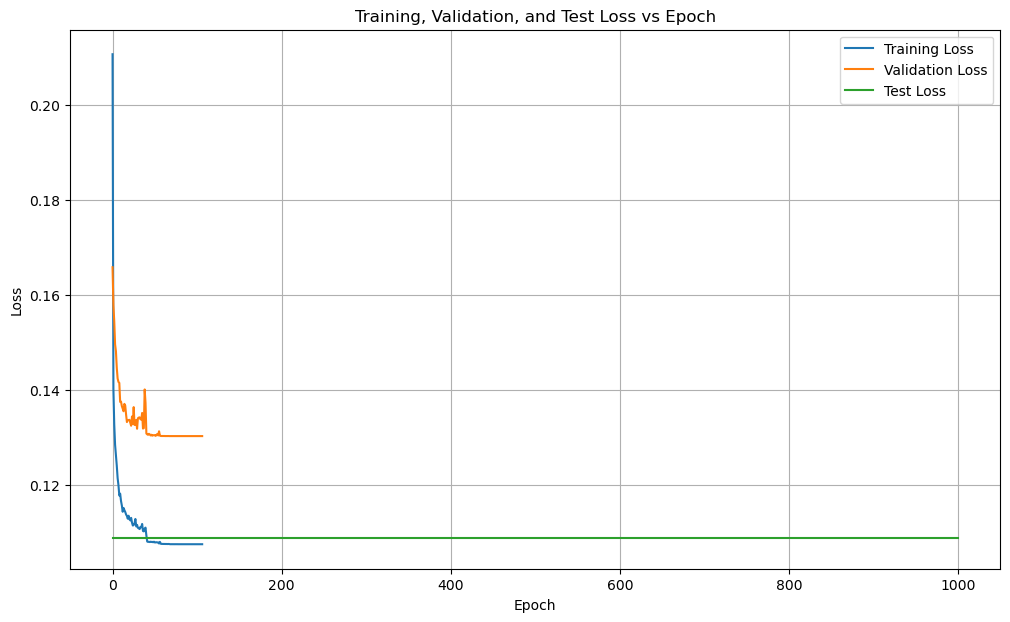

In [79]:
visualize_loss(history, results)

<div style="text-align: center;">
    Fig. 8.19. Training, Validation, and Test Loss vs Epoch.
</div>

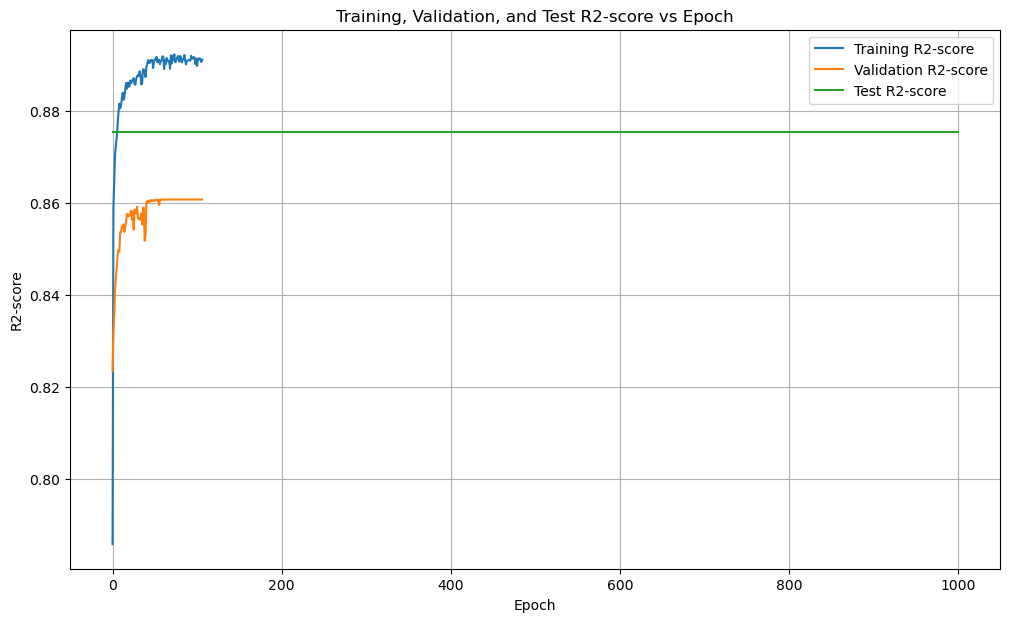

In [80]:
visualize_r2_score(history, results)

<div style="text-align: center;">
    Fig. 8.20. Training, Validation, and Test Loss vs Epoch.
</div>

The final R2-score:

In [81]:
r2_score_dict[f"{model_name}"] = {
        "r2_score_train": round(history.history["r2_score"][-1], 4), 
        "r2_score_val": round(history.history["val_r2_score"][-1], 4), 
        "r2_score_test": round(results[4], 4)
}

In [82]:
r2_score_dict[f"{model_name}"]

{'r2_score_train': 0.8912, 'r2_score_val': 0.8608, 'r2_score_test': 0.8754}

In [83]:
r2_score_dict

{'one_layer_128': {'r2_score_train': 0.9023,
  'r2_score_val': 0.8554,
  'r2_score_test': 0.8668},
 'two_layers_128_64': {'r2_score_train': 0.9475,
  'r2_score_val': 0.8101,
  'r2_score_test': 0.823},
 'one_layer_128_dropout': {'r2_score_train': 0.89,
  'r2_score_val': 0.861,
  'r2_score_test': 0.8801},
 'two_layers_128_64_dropout': {'r2_score_train': 0.9092,
  'r2_score_val': 0.8419,
  'r2_score_test': 0.8506},
 'one_layer_128_reg_l2_0.01': {'r2_score_train': 0.8867,
  'r2_score_val': 0.8572,
  'r2_score_test': 0.8757},
 'one_layer_128_reg_l2_0.02': {'r2_score_train': 0.8852,
  'r2_score_val': 0.8532,
  'r2_score_test': 0.8721},
 'one_layer_128_reg_l2_1': {'r2_score_train': 0.8753,
  'r2_score_val': 0.8427,
  'r2_score_test': 0.864},
 'two_layers_128_64_reg_l2_0.01': {'r2_score_train': 0.8859,
  'r2_score_val': 0.8535,
  'r2_score_test': 0.8758},
 'two_layers_128_64_reg_l2_1': {'r2_score_train': 0.8641,
  'r2_score_val': 0.8304,
  'r2_score_test': 0.8516},
 'one_layer_128_early_stoppi

## 1 Layer + Regularization (0.03) + Callbacks (EarlyStopping and ReduceLROnPlateau)

### Build, Train and Evaluate the Model

Build the model:

In [84]:
def build_model(input_shape, model_name):
    # Set architecture.
    """Builds the model."""
    model = Sequential(
        [
            Input(shape=(x_train.shape[1],), name="L1_Input_Layer"), 
            Dense(128, activation="relu", name="L2_Hidden_Layer_1", kernel_regularizer=l2(0.03)), 
            #Dropout(0.2),
            Dense(1, name="L3_Output_Layer")
        ],
        name=model_name
    )
    return model

Run the functions:

In [85]:
model_name = "one_layer_128_reg_l2_0.03_early_stopping_reduce_LR"
# Build the model.
model = build_model((x_train.shape[1],), model_name)
# Configure the model.
compile_model(model)
# Save the model.
save_model(model, f"models/{model_name}")
# Set the callbacks: EarlyStoppin, ReduceLROnPlateau
callbacks = [set_early_stopping(), set_lr()]
# Train the model.
history = train_model(model, callbacks)
# Save the history.
save_history(history, f"history/{model_name}.json")
# Evaluate the model.
results = model.evaluate(x_test, y_test)

Model: "one_layer_128_reg_l2_0.03_early_stopping_reduce_LR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L2_Hidden_Layer_1 (Dense)   (None, 128)               1408      
                                                                 
 L3_Output_Layer (Dense)     (None, 1)                 129       
                                                                 
Total params: 1537 (6.00 KB)
Trainable params: 1537 (6.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: models/one_layer_128_reg_l2_0.03_early_stopping_reduce_LR/assets


INFO:tensorflow:Assets written to: models/one_layer_128_reg_l2_0.03_early_stopping_reduce_LR/assets


Epoch 1/1000
98/98 [==============================] - 2s 13ms/step - loss: 0.6153 - mean_absolute_error: 0.2913 - mean_squared_error: 0.1831 - root_mean_squared_error: 0.4279 - r2_score: 0.8135 - val_loss: 0.4644 - val_mean_absolute_error: 0.2723 - val_mean_squared_error: 0.1595 - val_root_mean_squared_error: 0.3994 - val_r2_score: 0.8300 - lr: 0.0010
Epoch 2/1000
98/98 [==============================] - 1s 12ms/step - loss: 0.3575 - mean_absolute_error: 0.2577 - mean_squared_error: 0.1365 - root_mean_squared_error: 0.3695 - r2_score: 0.8593 - val_loss: 0.3095 - val_mean_absolute_error: 0.2610 - val_mean_squared_error: 0.1570 - val_root_mean_squared_error: 0.3962 - val_r2_score: 0.8329 - lr: 0.0010
Epoch 3/1000
98/98 [==============================] - 1s 10ms/step - loss: 0.2450 - mean_absolute_error: 0.2537 - mean_squared_error: 0.1329 - root_mean_squared_error: 0.3645 - r2_score: 0.8650 - val_loss: 0.2340 - val_mean_absolute_error: 0.2622 - val_mean_squared_error: 0.1543 - val_root_m

### Visualize the results

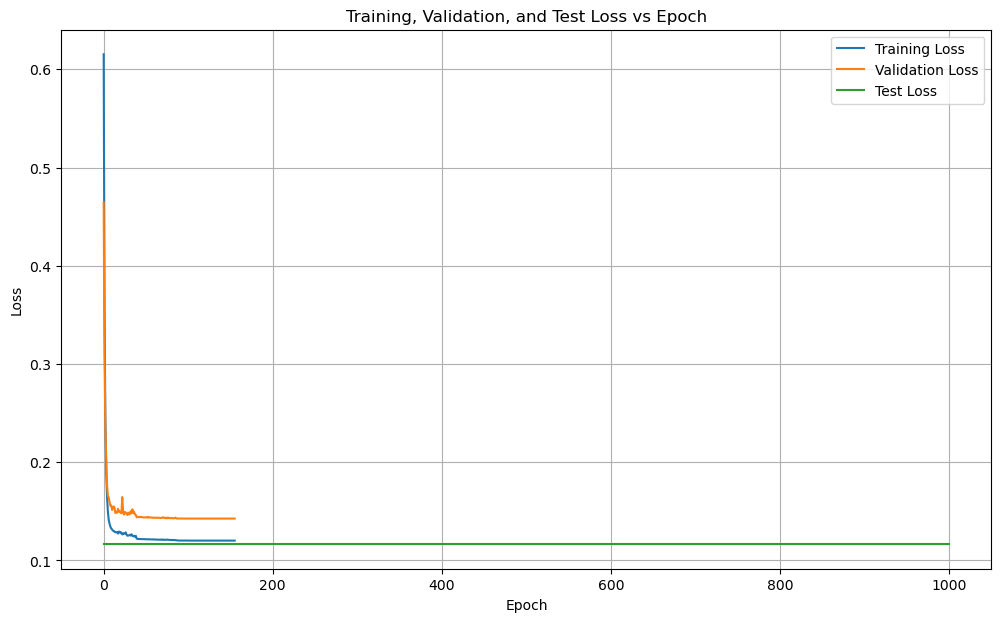

In [86]:
visualize_loss(history, results)

<div style="text-align: center;">
    Fig. 8.21. Training, Validation, and Test Loss vs Epoch.
</div>

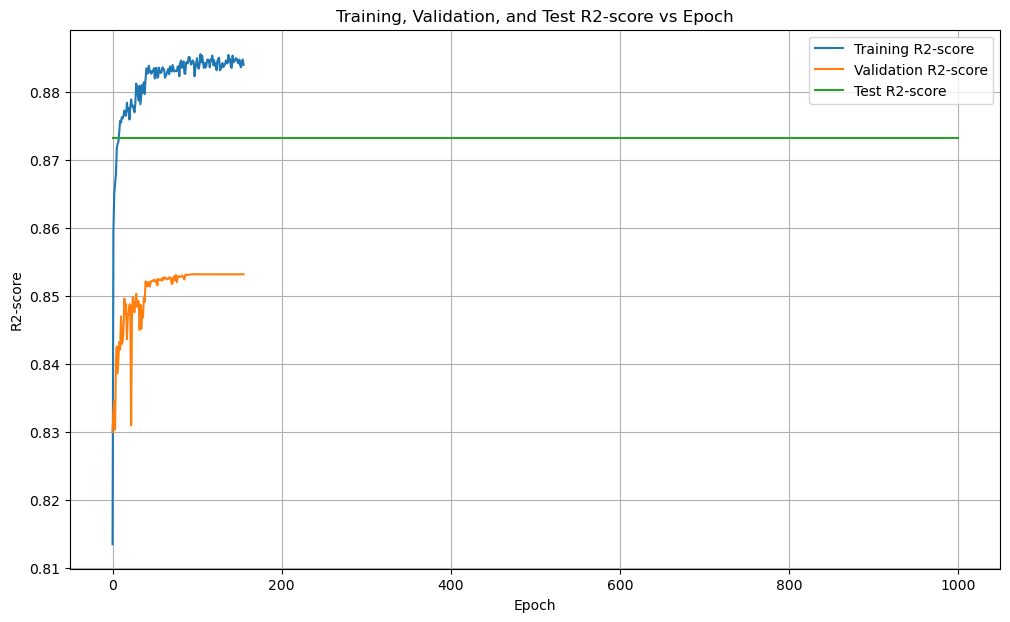

In [87]:
visualize_r2_score(history, results)

<div style="text-align: center;">
    Fig. 8.22. Training, Validation, and Test R2-score vs Epoch.
</div>

The final R2-score:

In [88]:
r2_score_dict[f"{model_name}"] = {
        "r2_score_train": round(history.history["r2_score"][-1], 4), 
        "r2_score_val": round(history.history["val_r2_score"][-1], 4), 
        "r2_score_test": round(results[4], 4)
}

In [89]:
r2_score_dict[f"{model_name}"]

{'r2_score_train': 0.884, 'r2_score_val': 0.8532, 'r2_score_test': 0.8732}

In [90]:
r2_score_dict

{'one_layer_128': {'r2_score_train': 0.9023,
  'r2_score_val': 0.8554,
  'r2_score_test': 0.8668},
 'two_layers_128_64': {'r2_score_train': 0.9475,
  'r2_score_val': 0.8101,
  'r2_score_test': 0.823},
 'one_layer_128_dropout': {'r2_score_train': 0.89,
  'r2_score_val': 0.861,
  'r2_score_test': 0.8801},
 'two_layers_128_64_dropout': {'r2_score_train': 0.9092,
  'r2_score_val': 0.8419,
  'r2_score_test': 0.8506},
 'one_layer_128_reg_l2_0.01': {'r2_score_train': 0.8867,
  'r2_score_val': 0.8572,
  'r2_score_test': 0.8757},
 'one_layer_128_reg_l2_0.02': {'r2_score_train': 0.8852,
  'r2_score_val': 0.8532,
  'r2_score_test': 0.8721},
 'one_layer_128_reg_l2_1': {'r2_score_train': 0.8753,
  'r2_score_val': 0.8427,
  'r2_score_test': 0.864},
 'two_layers_128_64_reg_l2_0.01': {'r2_score_train': 0.8859,
  'r2_score_val': 0.8535,
  'r2_score_test': 0.8758},
 'two_layers_128_64_reg_l2_1': {'r2_score_train': 0.8641,
  'r2_score_val': 0.8304,
  'r2_score_test': 0.8516},
 'one_layer_128_early_stoppi

## 2 Layers + Regularization (0.01) + Callbacks (EarlyStopping and ReduceLROnPlateau)

### Build, Train and Evaluate the Model

Build the model:

In [91]:
def build_model(input_shape, model_name):
    """Builds the model."""
    model = Sequential(
        [
            Input(shape=(x_train.shape[1],), name="L1_Input_Layer"), 
            Dense(128, activation="relu", name="L2_Hidden_Layer_1", kernel_regularizer=l2(0.01)), 
            #Dropout(0.2),
            Dense(64, activation="relu", name="L3_Hidden_Layer_2", kernel_regularizer=l2(0.01)), 
            #Dropout(0.2),
            Dense(1, name="L4_Output_Layer")
        ],
        name=model_name
    )
    return model

Run the functions:

In [92]:
model_name = "two_layers_128_64_reg_l2_0.01_early_stopping_reduce_LR"
# Build the model.
model = build_model((x_train.shape[1],), model_name)
# Configure the model.
compile_model(model)
# Save the model.
save_model(model, f"models/{model_name}")
# Set the callbacks: EarlyStoppin, ReduceLROnPlateau
callbacks = [set_early_stopping(), set_lr()]
# Train the model.
history = train_model(model, callbacks)
# Save the history.
save_history(history, f"history/{model_name}.json")
# Evaluate the model.
results = model.evaluate(x_test, y_test)

Model: "two_layers_128_64_reg_l2_0.01_early_stopping_reduce_LR"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 L2_Hidden_Layer_1 (Dense)   (None, 128)               1408      
                                                                 
 L3_Hidden_Layer_2 (Dense)   (None, 64)                8256      
                                                                 
 L4_Output_Layer (Dense)     (None, 1)                 65        
                                                                 
Total params: 9729 (38.00 KB)
Trainable params: 9729 (38.00 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
INFO:tensorflow:Assets written to: models/two_layers_128_64_reg_l2_0.01_early_stopping_reduce_LR/assets


INFO:tensorflow:Assets written to: models/two_layers_128_64_reg_l2_0.01_early_stopping_reduce_LR/assets


Epoch 1/1000
98/98 [==============================] - 2s 19ms/step - loss: 0.9396 - mean_absolute_error: 0.2950 - mean_squared_error: 0.1886 - root_mean_squared_error: 0.4342 - r2_score: 0.8111 - val_loss: 0.6554 - val_mean_absolute_error: 0.2629 - val_mean_squared_error: 0.1600 - val_root_mean_squared_error: 0.4000 - val_r2_score: 0.8293 - lr: 0.0010
Epoch 2/1000
98/98 [==============================] - 1s 14ms/step - loss: 0.4944 - mean_absolute_error: 0.2560 - mean_squared_error: 0.1360 - root_mean_squared_error: 0.3688 - r2_score: 0.8622 - val_loss: 0.4078 - val_mean_absolute_error: 0.2547 - val_mean_squared_error: 0.1534 - val_root_mean_squared_error: 0.3916 - val_r2_score: 0.8361 - lr: 0.0010
Epoch 3/1000
98/98 [==============================] - 1s 14ms/step - loss: 0.3269 - mean_absolute_error: 0.2499 - mean_squared_error: 0.1303 - root_mean_squared_error: 0.3609 - r2_score: 0.8686 - val_loss: 0.3025 - val_mean_absolute_error: 0.2697 - val_mean_squared_error: 0.1524 - val_root_m

### Visualize the results

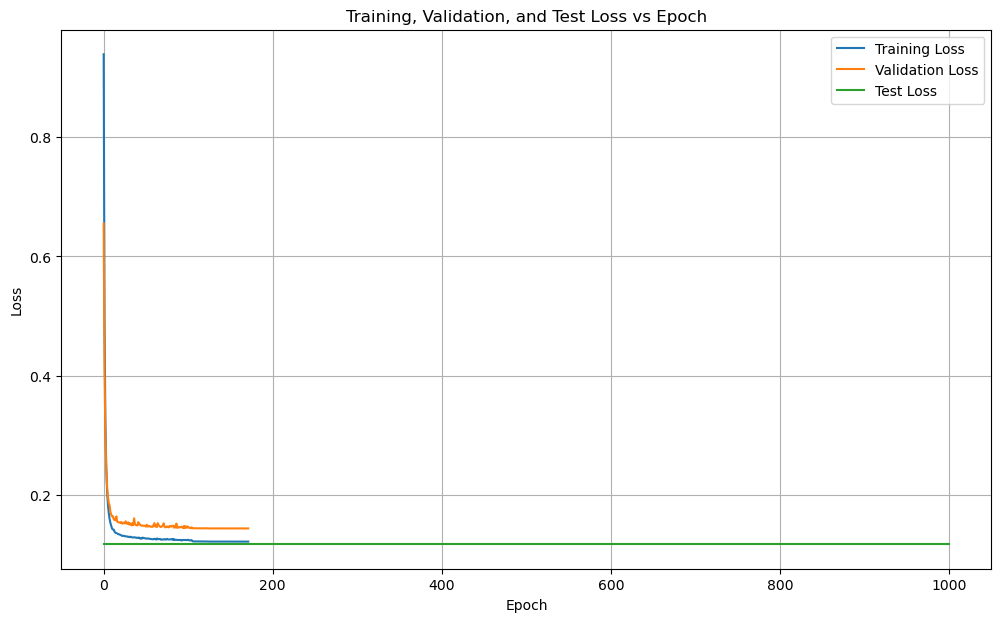

In [93]:
visualize_loss(history, results)

<div style="text-align: center;">
    Fig. 8.23. Training, Validation, and Test Loss vs Epoch.
</div>

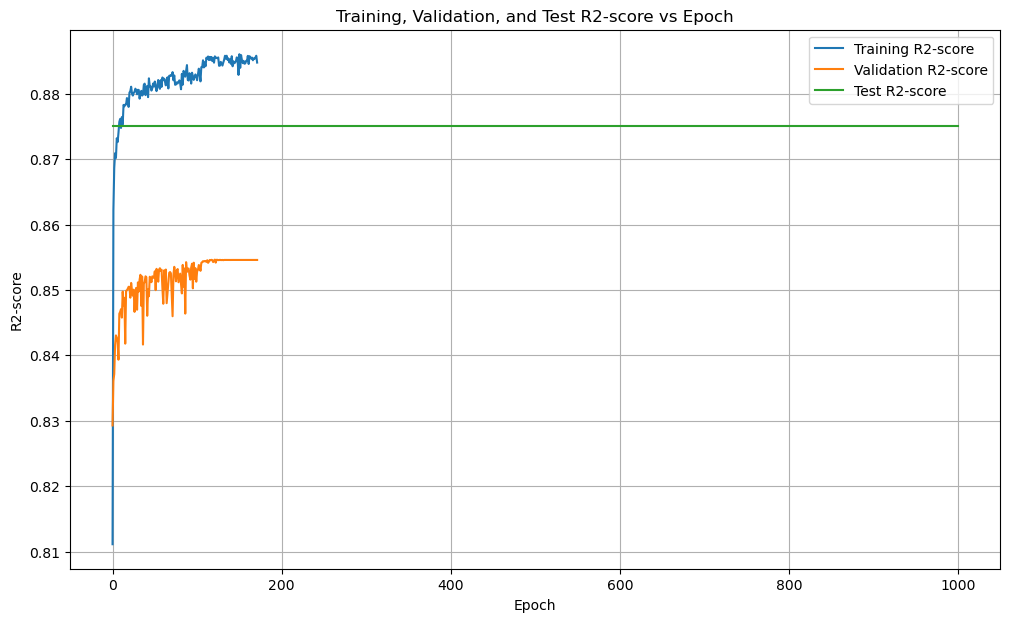

In [94]:
visualize_r2_score(history, results)

<div style="text-align: center;">
    Fig. 8.24. Training, Validation, and Test R2-score vs Epoch.
</div>

The final R2-score:

In [95]:
r2_score_dict[f"{model_name}"] = {
        "r2_score_train": round(history.history["r2_score"][-1], 4), 
        "r2_score_val": round(history.history["val_r2_score"][-1], 4), 
        "r2_score_test": round(results[4], 4)
}

In [96]:
r2_score_dict[f"{model_name}"]

{'r2_score_train': 0.8848, 'r2_score_val': 0.8546, 'r2_score_test': 0.8751}

In [97]:
r2_score_dict

{'one_layer_128': {'r2_score_train': 0.9023,
  'r2_score_val': 0.8554,
  'r2_score_test': 0.8668},
 'two_layers_128_64': {'r2_score_train': 0.9475,
  'r2_score_val': 0.8101,
  'r2_score_test': 0.823},
 'one_layer_128_dropout': {'r2_score_train': 0.89,
  'r2_score_val': 0.861,
  'r2_score_test': 0.8801},
 'two_layers_128_64_dropout': {'r2_score_train': 0.9092,
  'r2_score_val': 0.8419,
  'r2_score_test': 0.8506},
 'one_layer_128_reg_l2_0.01': {'r2_score_train': 0.8867,
  'r2_score_val': 0.8572,
  'r2_score_test': 0.8757},
 'one_layer_128_reg_l2_0.02': {'r2_score_train': 0.8852,
  'r2_score_val': 0.8532,
  'r2_score_test': 0.8721},
 'one_layer_128_reg_l2_1': {'r2_score_train': 0.8753,
  'r2_score_val': 0.8427,
  'r2_score_test': 0.864},
 'two_layers_128_64_reg_l2_0.01': {'r2_score_train': 0.8859,
  'r2_score_val': 0.8535,
  'r2_score_test': 0.8758},
 'two_layers_128_64_reg_l2_1': {'r2_score_train': 0.8641,
  'r2_score_val': 0.8304,
  'r2_score_test': 0.8516},
 'one_layer_128_early_stoppi

## The Final Table of Metrics

Create the df from the dictionary of metrics:

In [98]:
df_test = pd.DataFrame(r2_score_dict).T 
df_test

r2_score_train   
one_layer_128                                               0.9023  \
two_layers_128_64                                           0.9475   
one_layer_128_dropout                                       0.8900   
two_layers_128_64_dropout                                   0.9092   
one_layer_128_reg_l2_0.01                                   0.8867   
one_layer_128_reg_l2_0.02                                   0.8852   
one_layer_128_reg_l2_1                                      0.8753   
two_layers_128_64_reg_l2_0.01                               0.8859   
two_layers_128_64_reg_l2_1                                  0.8641   
one_layer_128_early_stopping_reduce_LR                      0.8912   
one_layer_128_reg_l2_0.03_early_stopping_reduce_LR          0.8840   
two_layers_128_64_reg_l2_0.01_early_stopping_re...          0.8848   

                                                    r2_score_val   
one_layer_128                                             0.8554  \
two_layers_128_64                                         0.8101   
one_layer_128_dropout                                     0.8610   
two_layers_128_64_dropout                                 0.8419   
one_layer_128_reg_l2_0.01                                 0.8572   
one_layer_128_reg_l2_0.02                                 0.8532   
one_layer_128_reg_l2_1                                    0.8427   
two_layers_128_64_reg_l2_0.01                             0.8535   
two_layers_128_64_reg_l2_1                                0.8304   
one_layer_128_early_stopping_reduce_LR                    0.8608   
one_layer_128_reg_l2_0.03_early_stopping_reduce_LR        0.8532   
two_layers_128_64_reg_l2_0.01_early_stopping_re...        0.8546   

                                                    r2_score_test  
one_layer_128                                              0.8668  
two_layers_128_64                                          0.8230  
one_layer_128_dropout                                      0.8801  
two_layers_128_64_dropout                                  0.8506  
one_layer_128_reg_l2_0.01                                  0.8757  
one_layer_128_reg_l2_0.02                                  0.8721  
one_layer_128_reg_l2_1                                     0.8640  
two_layers_128_64_reg_l2_0.01                              0.8758  
two_layers_128_64_reg_l2_1                                 0.8516  
one_layer_128_early_stopping_reduce_LR                     0.8754  
one_layer_128_reg_l2_0.03_early_stopping_reduce_LR         0.8732  
two_layers_128_64_reg_l2_0.01_early_stopping_re...         0.8751

Plot the R2-score metrics for training, validation and test datasets:

In [100]:
# Extract the 3 color code in the format "#4C72B0"
deep_colors = sns.color_palette("deep", len(df_test.columns)).as_hex()

# Melt the dataframe to a long format suitable for the bar plot
df_melted = df_test.reset_index().melt(id_vars=["index"], value_vars=df_test.columns)

# Set the plot.
fig = px.bar(df_melted, 
             x="index", 
             y="value",
             color="variable", 
             barmode="group", 
             title="R2-score for Different Models",
             labels={"index": "Model", "value": "R2-score"},
             color_discrete_sequence=deep_colors,
             text="value"
)

# Update the y-axis range if desired
fig.update_layout(
    yaxis=dict(range=[0.75, 1]),
    title_x=0.5,
    height=600  # You can adjust this value as per your needs
)

fig.update_traces(texttemplate="%{text:.4f}", textposition="inside", textangle=270)
# Show the plot.
fig.show()

<div style="text-align: center;">
    Fig. 8.25. R2-score Metrics for Different Models.
</div>

## Conclusions

- Regularization, dropout, early stopping, and reduction of learning rate help to reduce overfitting.
- Early stopping helps to find a solution much faster.
- Simple neural networks help to achieve an R2-score of ~0.8751.